In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from mopet import mopet
from scipy.signal import find_peaks

from synchronization import plots
from synchronization import runner
from synchronization import constants
from synchronization import processing

# ING Network

In this notebook we model two interconnected inhibitory networks. Gamma rhythm is created by ING mechanism.

We explore the effect on noise strength and try to replicate Meng & Rieckes result.

Based on our findings for the ING model, we move forward to the PING model.

**ING network**
* 1000 Neurons in each Network
* Low Recurrent inhibition


In [2]:
params = {
    "runtime": 500.0,
    
    "ou_enabled": [False, False],
    
    "model_EI": False,
    
    "poisson_enabled": [True, True],
    "poisson_variance": 0.5,
    "poisson_p": 0.85,
    "poisson_size": 800,
    "poisson_mean_input": 300,
    "poisson_I_enabled": True,
    "poisson_I_ratio": 1.0,
    
    "N_pop": 2,
    "net_record_spikes": 200,    
    
    # Only Synaptic Strengths for I<->I.
    "J_ppee": 0.0,
    "J_ppei": 0.0,
    "J_ppii": 0.15,
    
    "J_itoi": 0.4,
    "J_etoe": 0.0,
    "J_etoi": 0.0,
    "J_itoe": 0.0,
    
    # Only connectivity for I to I, all-to-all.
    "p_ppee": 0.00,
    "p_ppei": 0.00,
    "p_ppii": 1.0,
    "p_etoi": 0.0,
    "p_etoe": 0,
    "p_itoe": 0.0,
    "p_itoi": 1.0,
    
    "syn_net_inh": True,
    "syn_net_exc": False,
    
    # Time Constants
    "tau_GABA": 20.0,
    
    "const_delay": 0.0,
    
    "N_e": 1,
    "N_i": 1000,
}

## ING Network with weak coupling and weak noise

We expect to see then almost no overlap in the area around the dominant frequency.

In [15]:
params_mid = dict(params)
params_mid.update({
    "runtime": 5000,
    "poisson_variance": 0.5,
    "net_record_spikes": 1000,
    # reduce time decay of GABA
    "tau_GABA": 20.0,    
})

# GABA Decay Values < 40 can still considered be realsitic? (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2666407/)

"""
1. Want to reduce the frequency (not amplitude) and keep a strong ING rhythm
* play around with tau_GABA
* reduce mean noise input
* reduce or increase inhibition?
* Any other time constants?
* Reduce influence between networks? I already see overlap in their frequency bands..

2. Have to analyze if I can keep peak frequency the same with increasing noise strength. Atm peak frequency increases as well, goes up to 80

"""

'\n1. Want to reduce the frequency (not amplitude) and keep a strong ING rhythm\n* play around with tau_GABA\n* reduce mean noise input\n* reduce or increase inhibition?\n* Any other time constants?\n* Reduce influence between networks? I already see overlap in their frequency bands..\n\n2. Have to analyze if I can keep peak frequency the same with increasing noise strength. Atm peak frequency increases as well, goes up to 80\n\n'

In [23]:
model = runner.run(
    modified_params=params_mid,
    file_name="ING_1",
    load=True
)

Average E firing frequency: 0.0
Average I firing frequency: 4.80244114301807
Global Order Parameter value of: 0.671141828501148
Mean Phase Coherence 0.2820760062436991
Computing within synchronization for network 1 and 2
Within Synchronization of Network 1 0.878711281005449
Within Synchronization of Network 2 0.8905662818353474


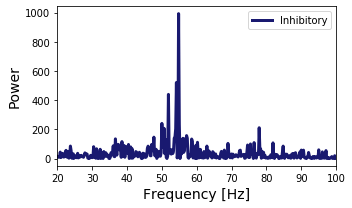

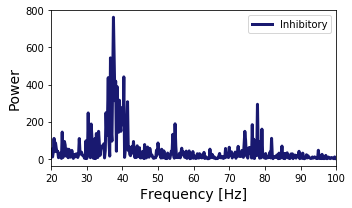

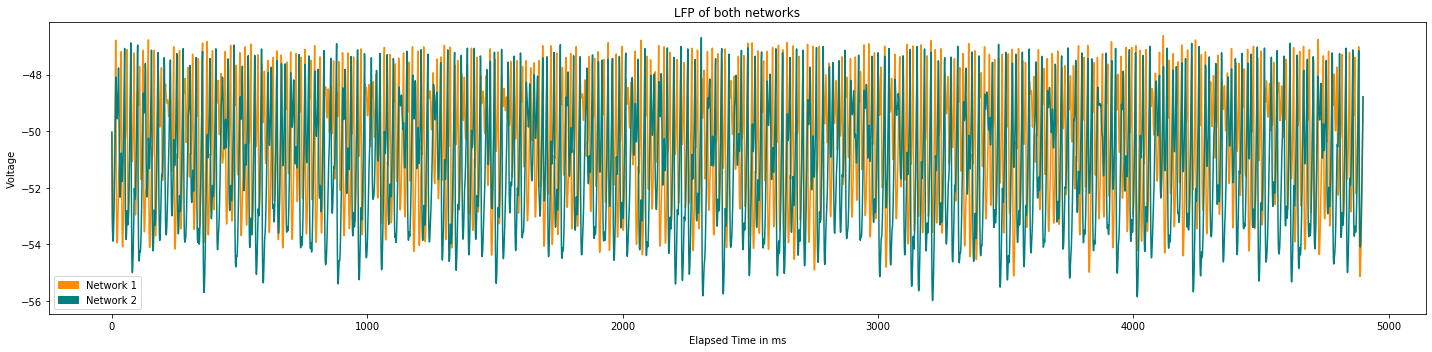

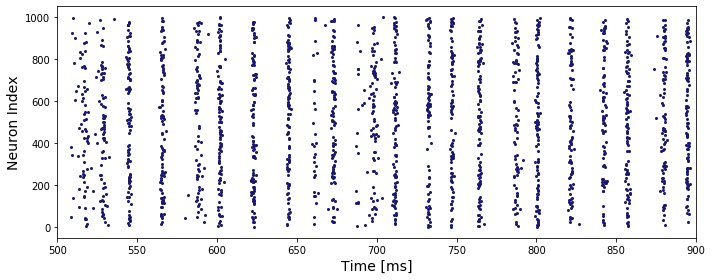

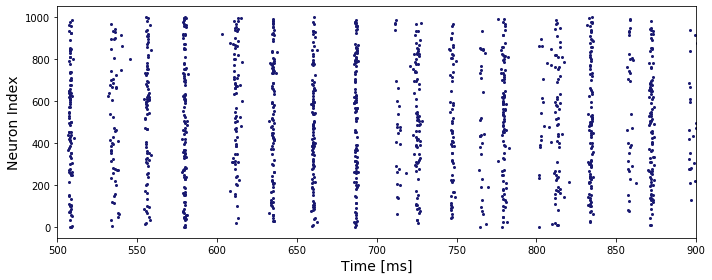

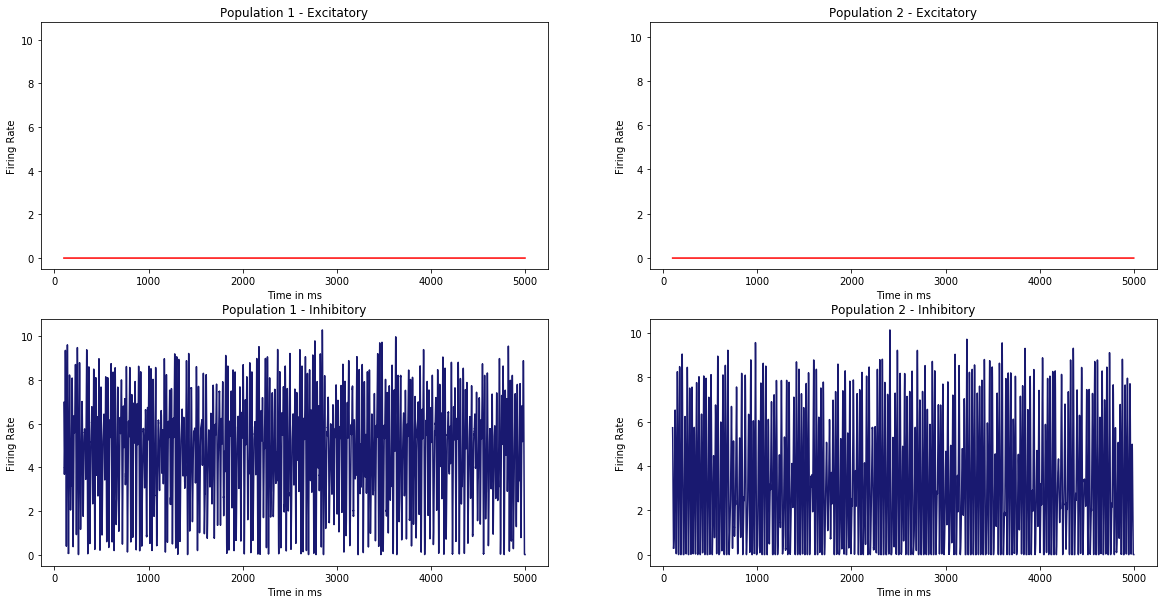

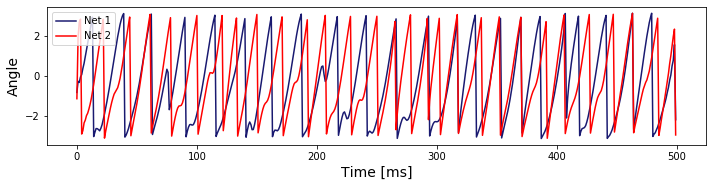

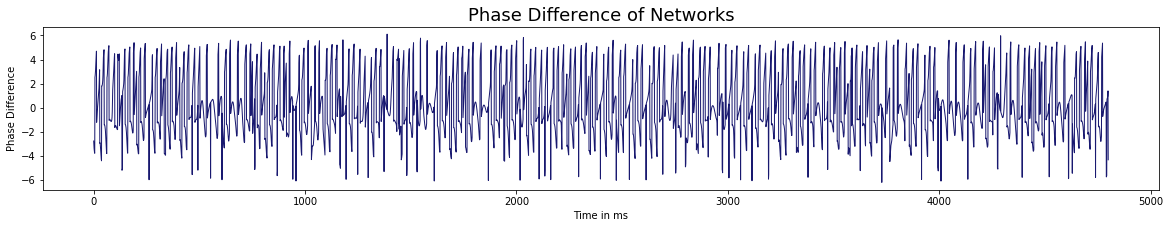

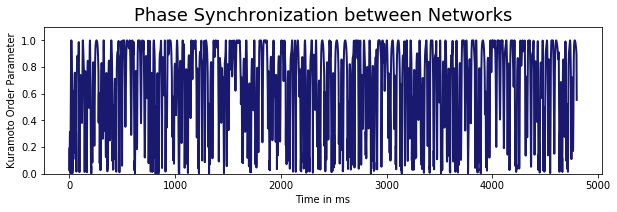

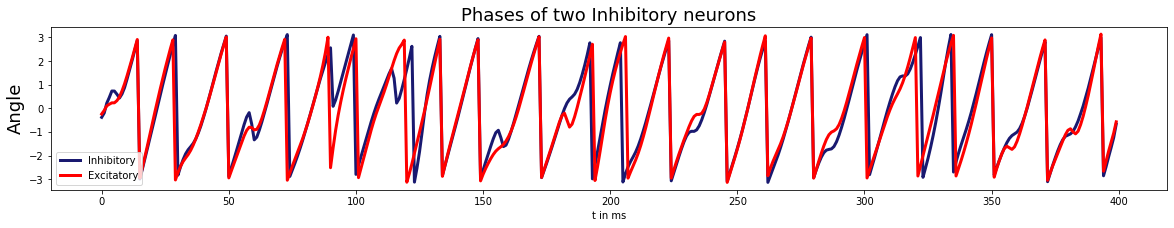

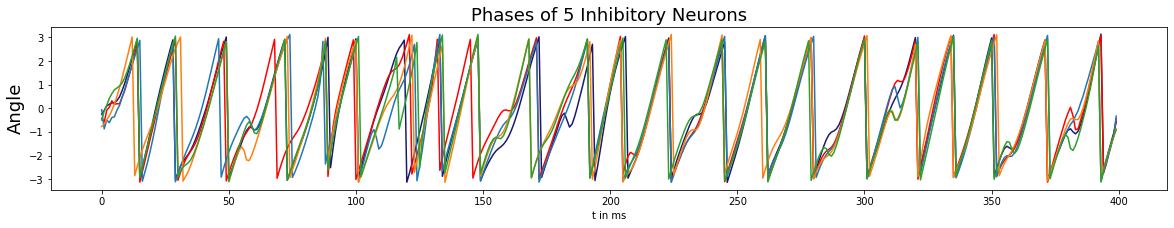

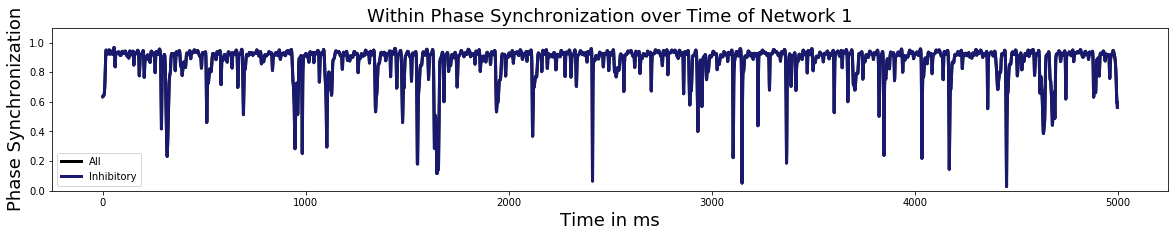

In [24]:
plots.plot_results(model, full_raster=False, psd_group="INH", x_max_psd=100, x_min_psd=20, folder="ING_weak_noise", save=True, phase_analysis=True)

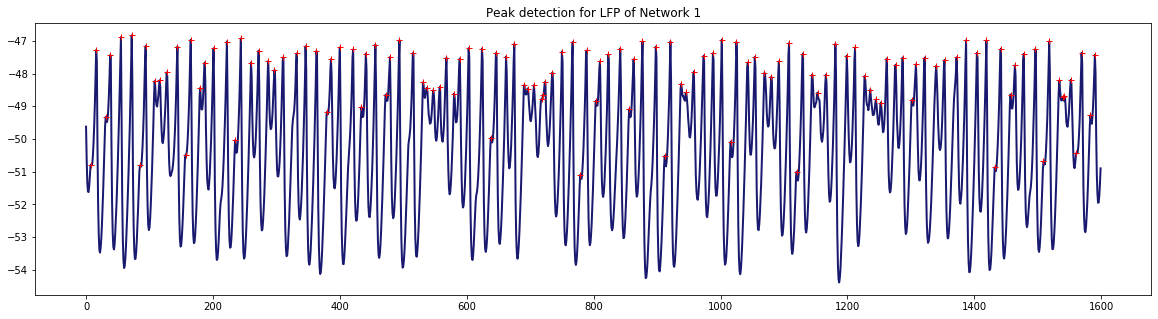

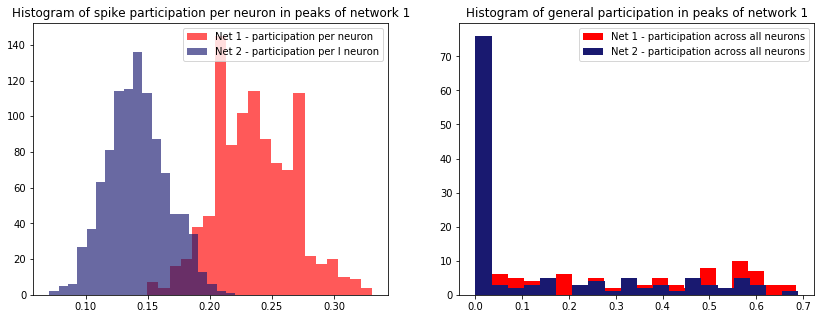

In [25]:
plots.spike_participation_histograms(model)

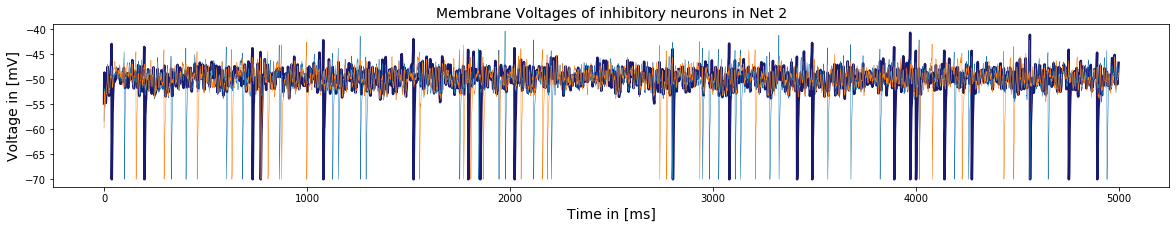

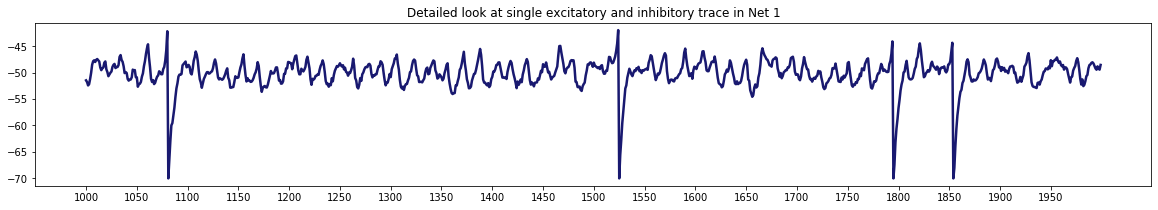

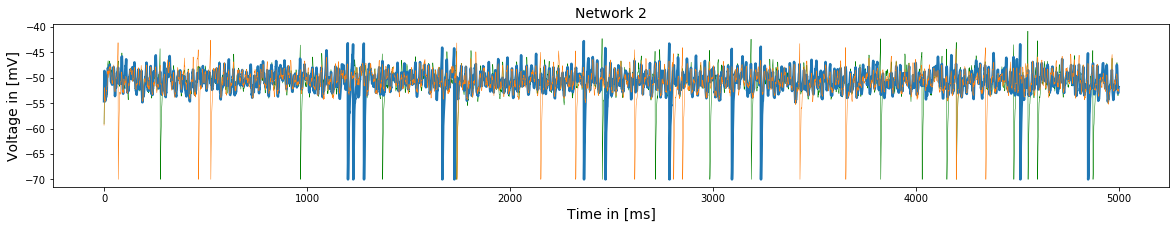

In [20]:
plots.membrane_potentials_sample(model, detail_window=(1000, 2000))

49
951


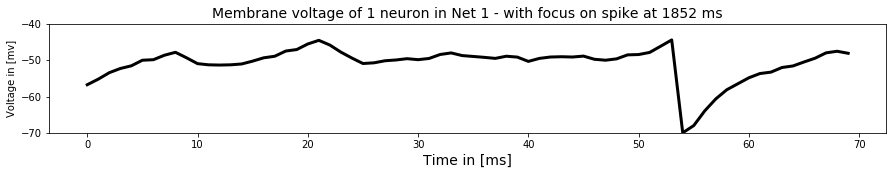

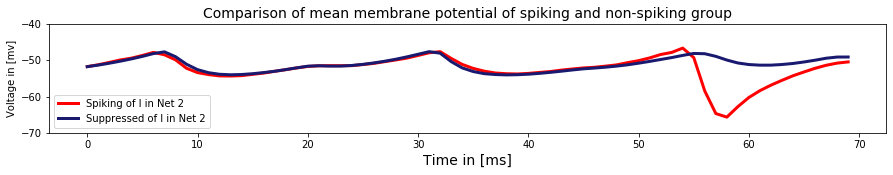

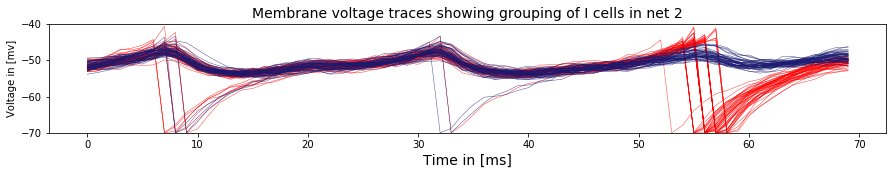

In [22]:
w = (1800, 1870)

v = model["v_all_neurons_i1"]
v2 = model["v_all_neurons_i2"]

plots.spike_variability_analysis(v, v2, window=w, t_s=1852, t_width=(6, 6))

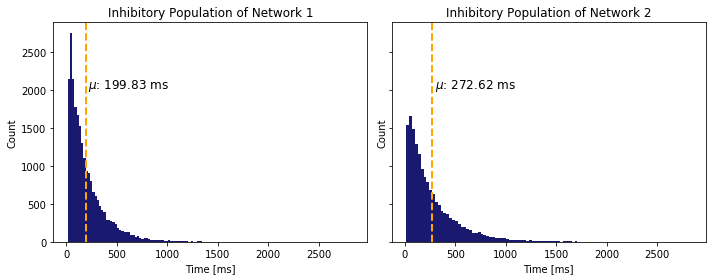

In [26]:
plots.isi_histograms(model, bins=100, filter_outlier=False, folder="ING", key="normal")

## Synchronizing both networks by increasing network coupling

Increased network coupling will synchronize both networks.

### Small Increase in network coupling -> we see first effects

Starting simulation at t=0. s for a duration of 5. s
1.32885 s (26%) simulated in 10s, estimated 28s remaining.
2.59305 s (51%) simulated in 20s, estimated 19s remaining.
3.92035 s (78%) simulated in 30s, estimated 8s remaining.
5. s (100%) simulated in 38s


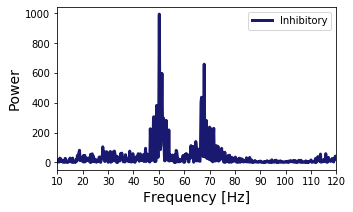

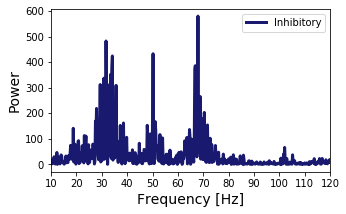

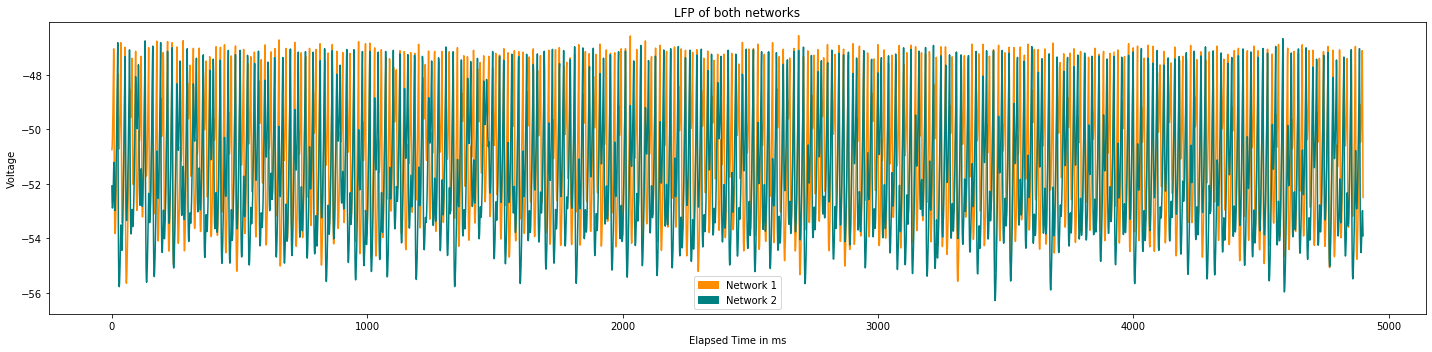

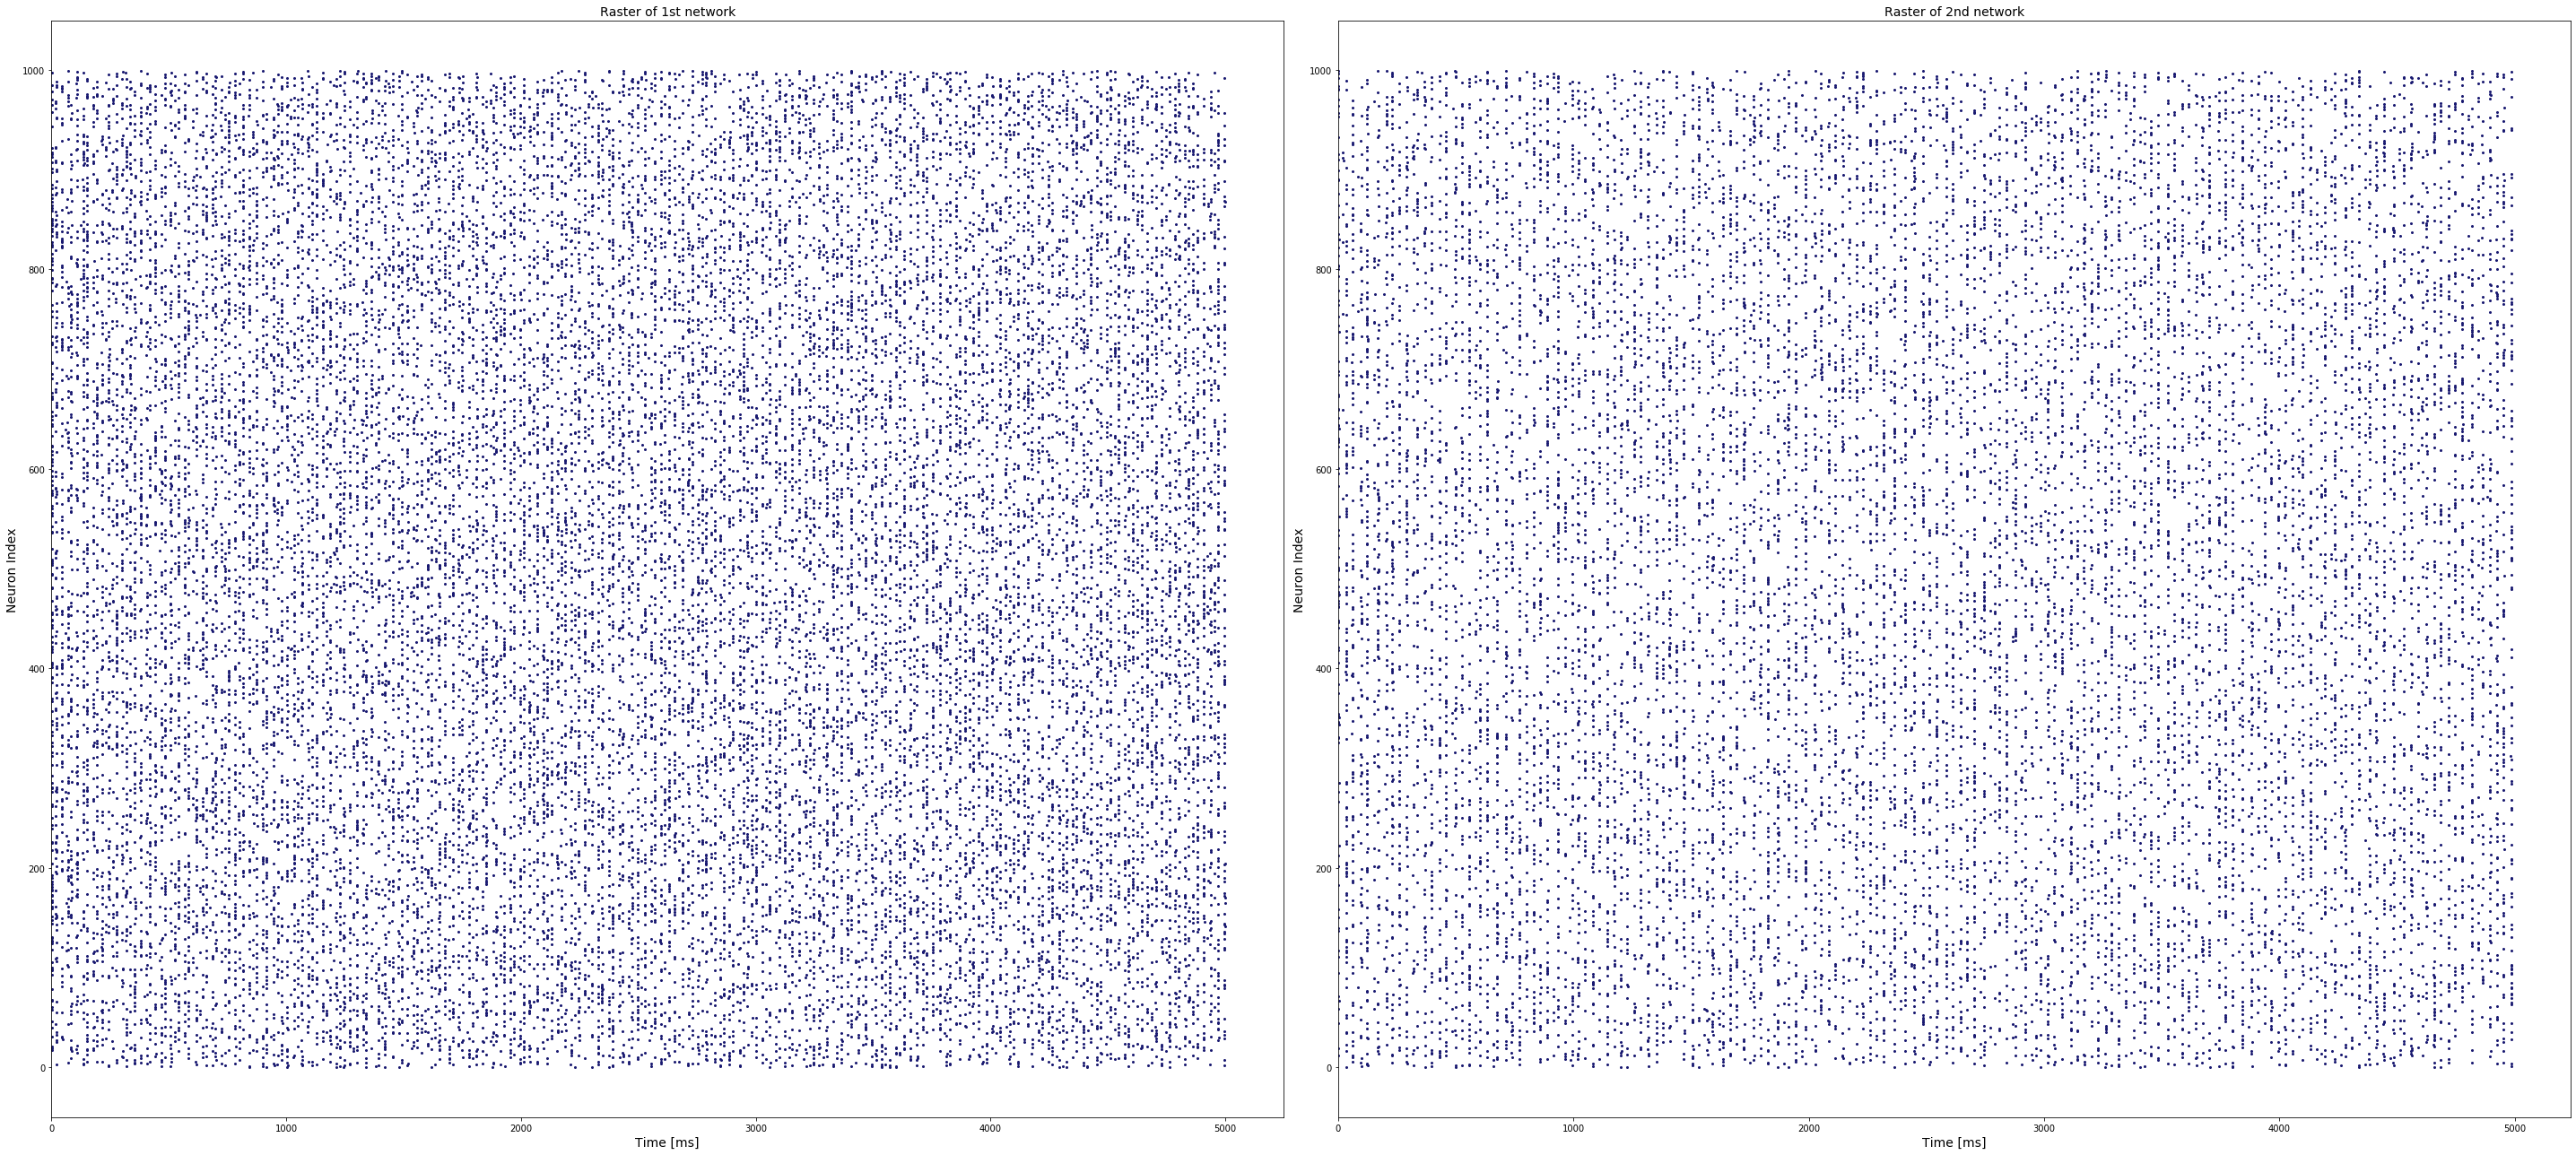

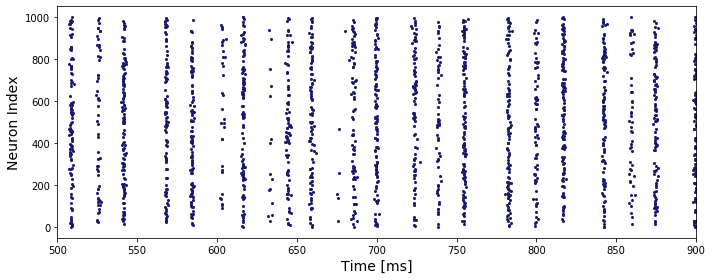

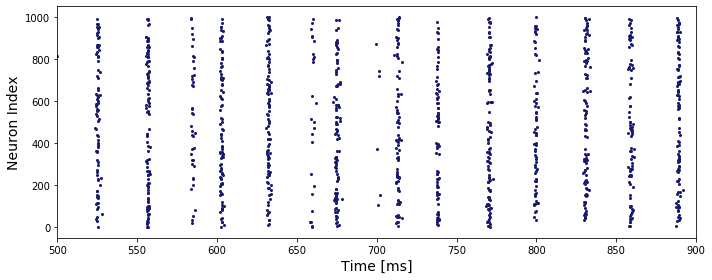

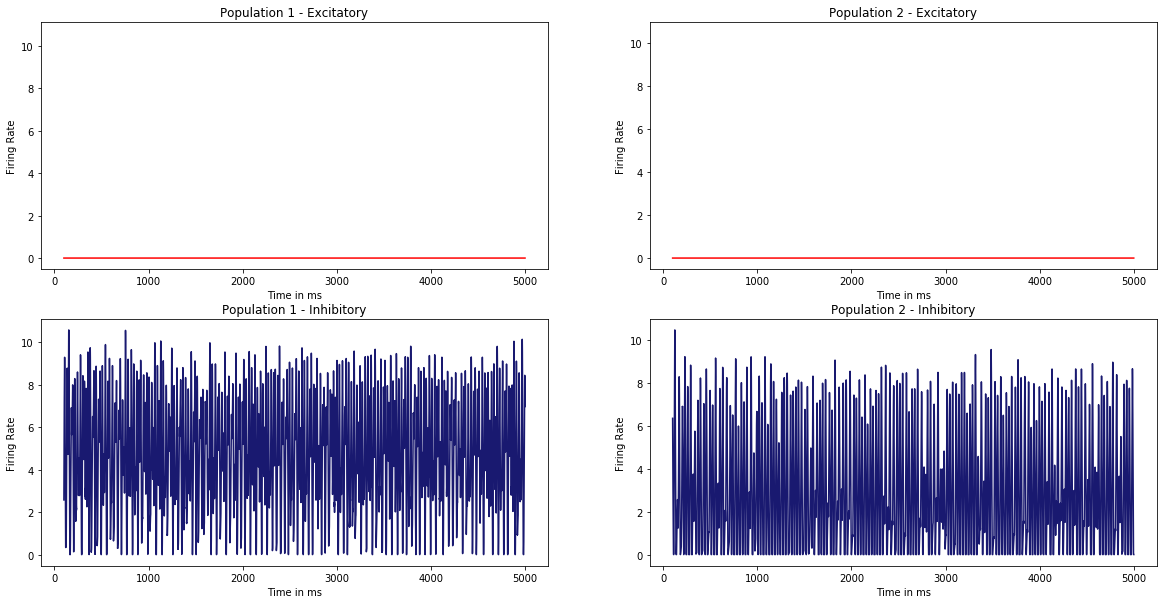

In [40]:
synch = dict(params)
synch.update({
    "runtime": 5000,
    "J_ppii": 0.2,
    "poisson_variance": 0.5,
    "net_record_spikes": 1000,    
})
model = runner.run(
    modified_params=synch
)

plots.plot_results(model, full_raster=True, psd_group="INH")

### Further increase in network coupling leads to 1:1 entrainment

In [27]:
synch = dict(params)
synch.update({
    "runtime": 5000,
    "J_ppii": 0.3,
    "poisson_variance": 0.5,
    "net_record_spikes": 1000,     
})

model = runner.run(
    modified_params=synch,
    file_name="ING_coupling",
    load=True
)

Average E firing frequency: 0.0
Average I firing frequency: 5.631424063934888
Global Order Parameter value of: 0.9955104964366448
Mean Phase Coherence 0.9976487550871754
Computing within synchronization for network 1 and 2
Within Synchronization of Network 1 0.933406071081886
Within Synchronization of Network 2 0.9750700049555948


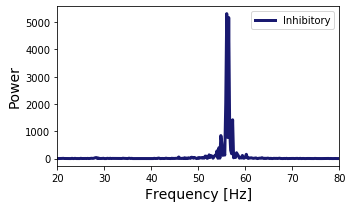

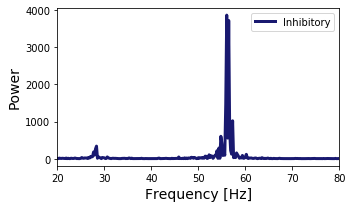

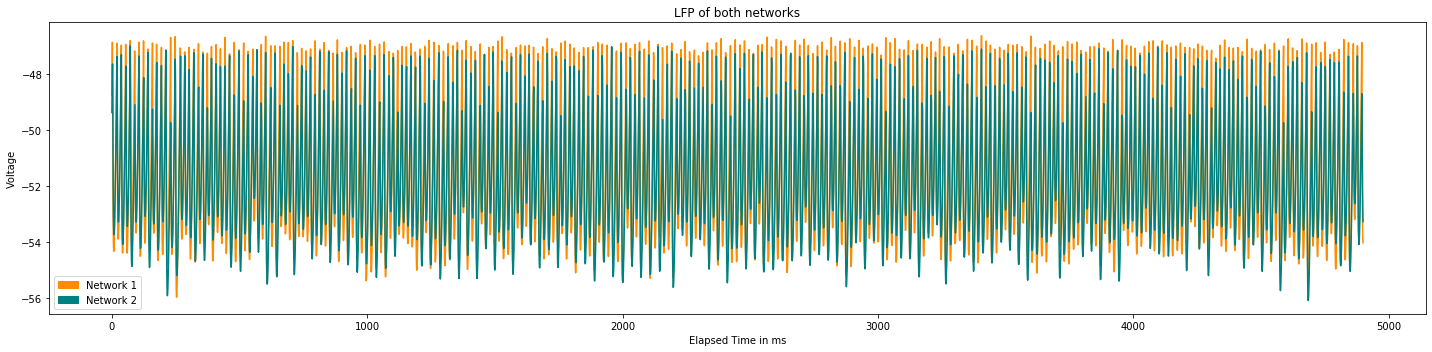

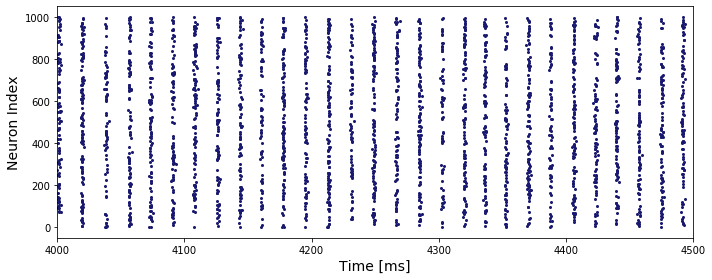

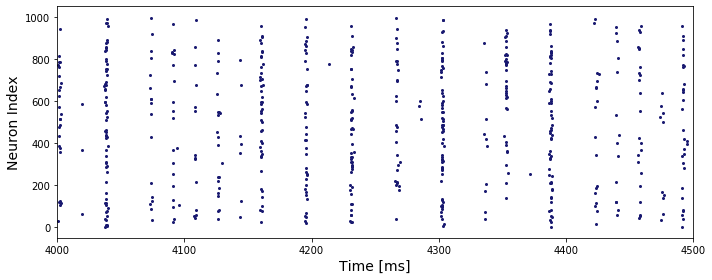

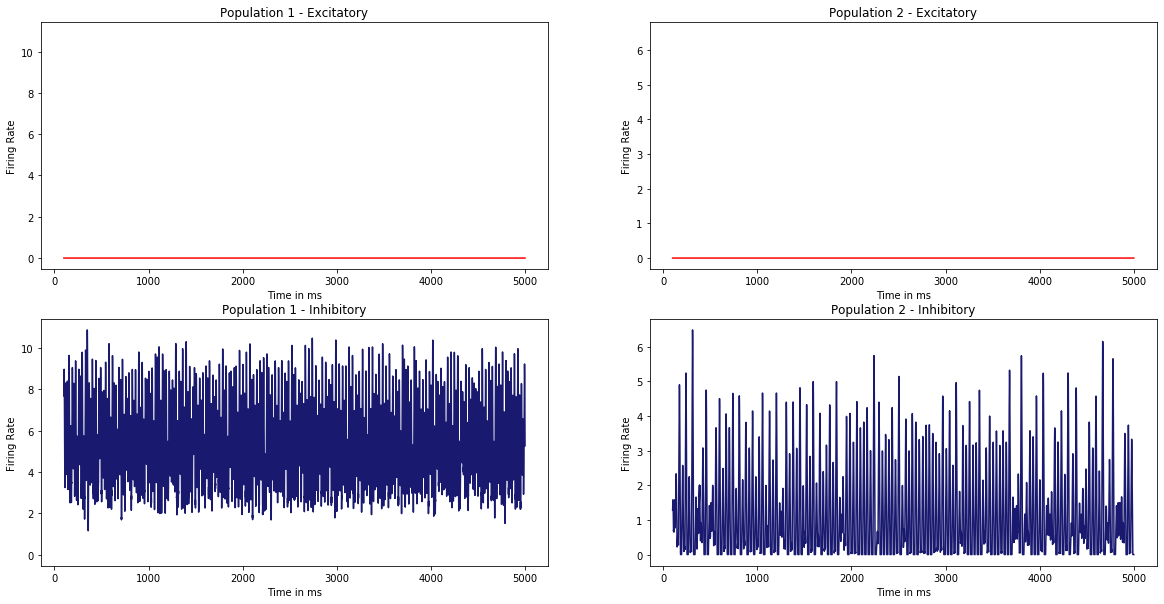

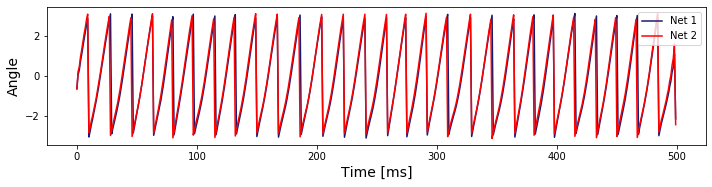

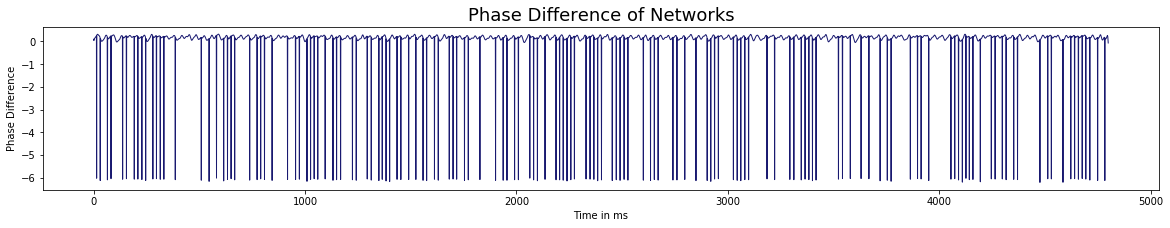

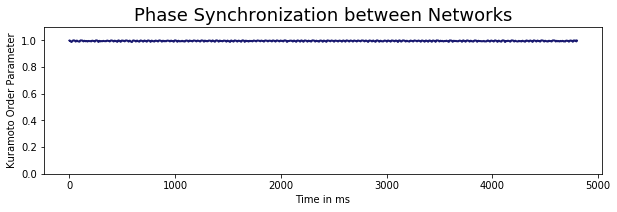

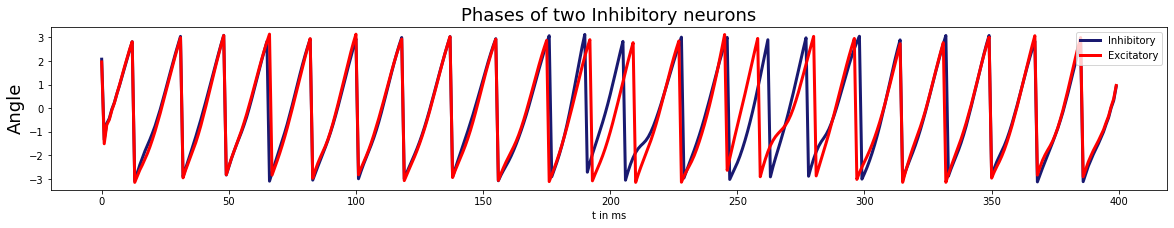

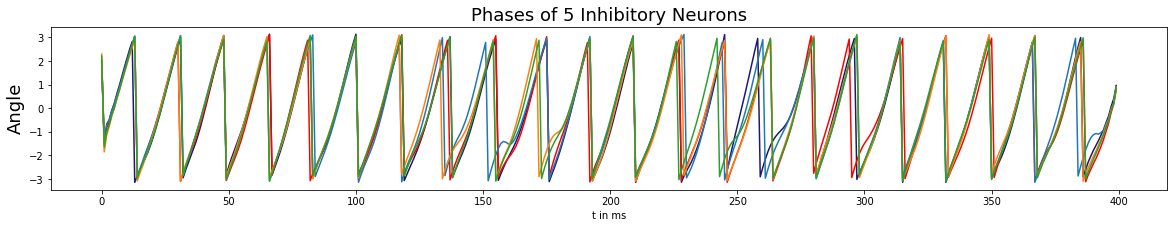

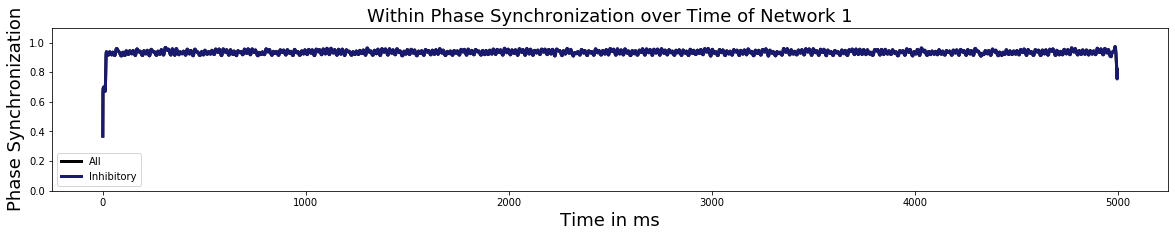

In [20]:
plots.plot_results(model, full_raster=False, psd_group="INH", x_max_psd=80, x_min_psd=20, raster_right=2000, folder="ING_strong_coupling", save=True, phase_analysis=True, excerpt_x_left=4000, excerpt_x_right=4500)

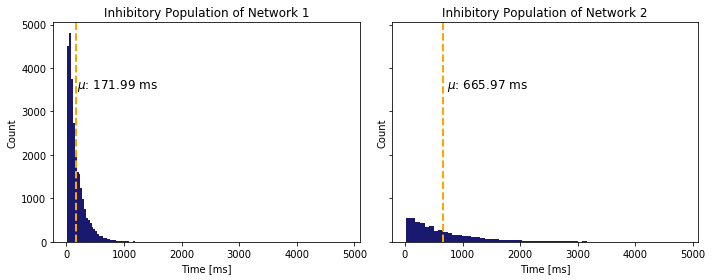

In [30]:
plots.isi_histograms(model, folder="ING", key="coupling-synch", filter_outlier=False)

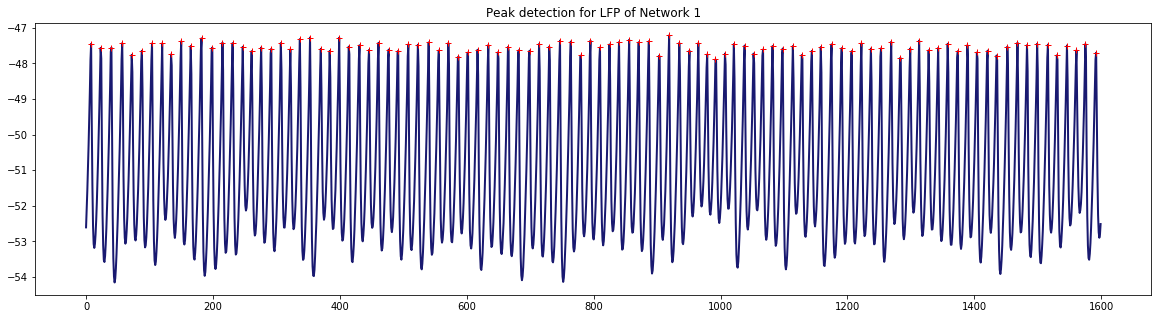

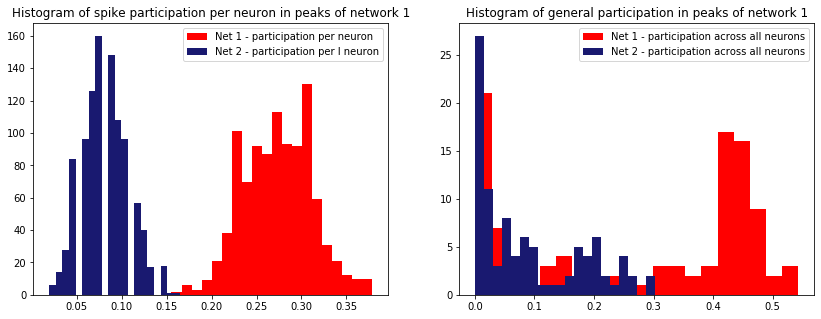

In [12]:
plots.spike_participation_histograms(model)

## Increase in noise leads to synchronization!

In [31]:
synch = dict(params)
synch.update({
    "runtime": 5000,
    "poisson_variance": 1.5,
    "net_record_spikes": 1000,  
})

model = runner.run(
    modified_params=synch,
    file_name="ING-noise-synch",
    load=True
)

Average E firing frequency: 0.0
Average I firing frequency: 4.750555113595441
Global Order Parameter value of: 0.8489351001518146
Mean Phase Coherence 0.5558164197218076
Computing within synchronization for network 1 and 2
Within Synchronization of Network 1 0.6023801105603193
Within Synchronization of Network 2 0.5780626474718531


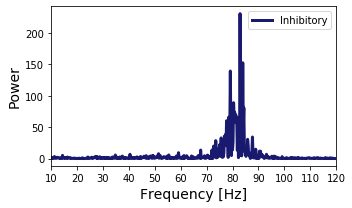

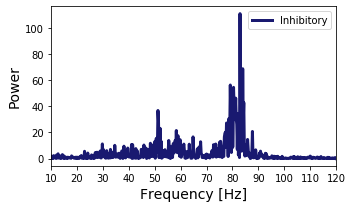

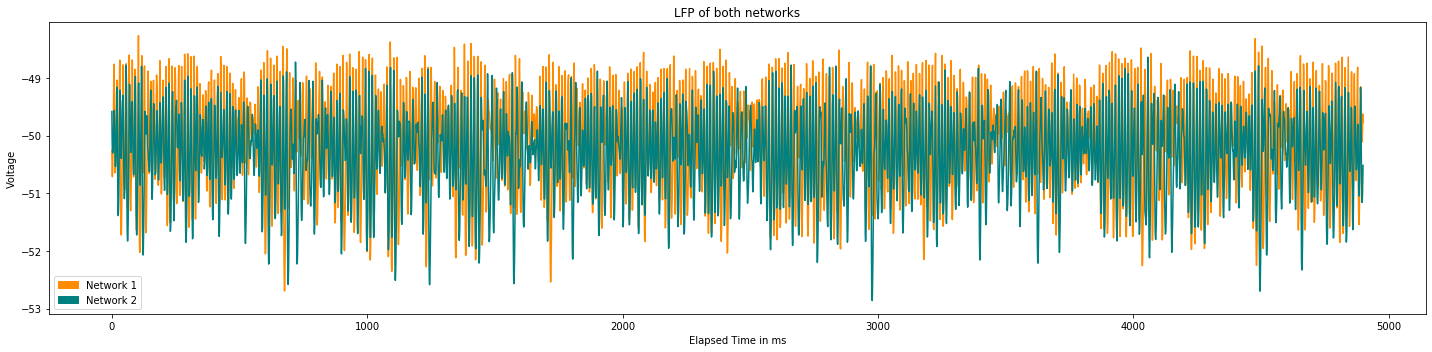

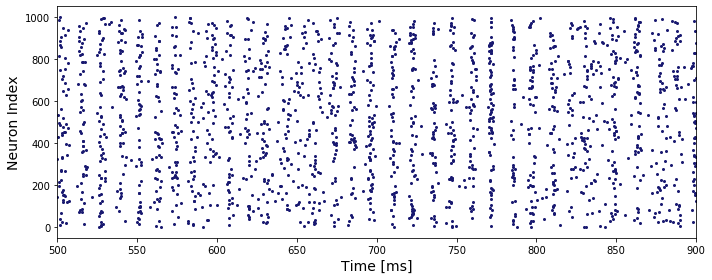

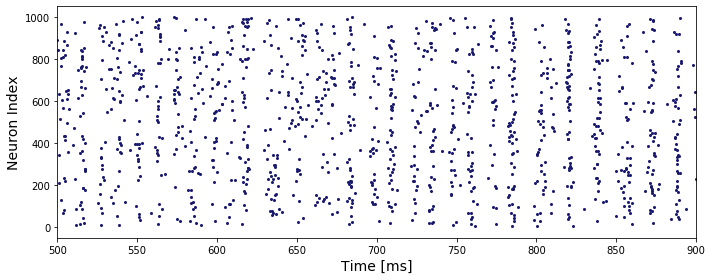

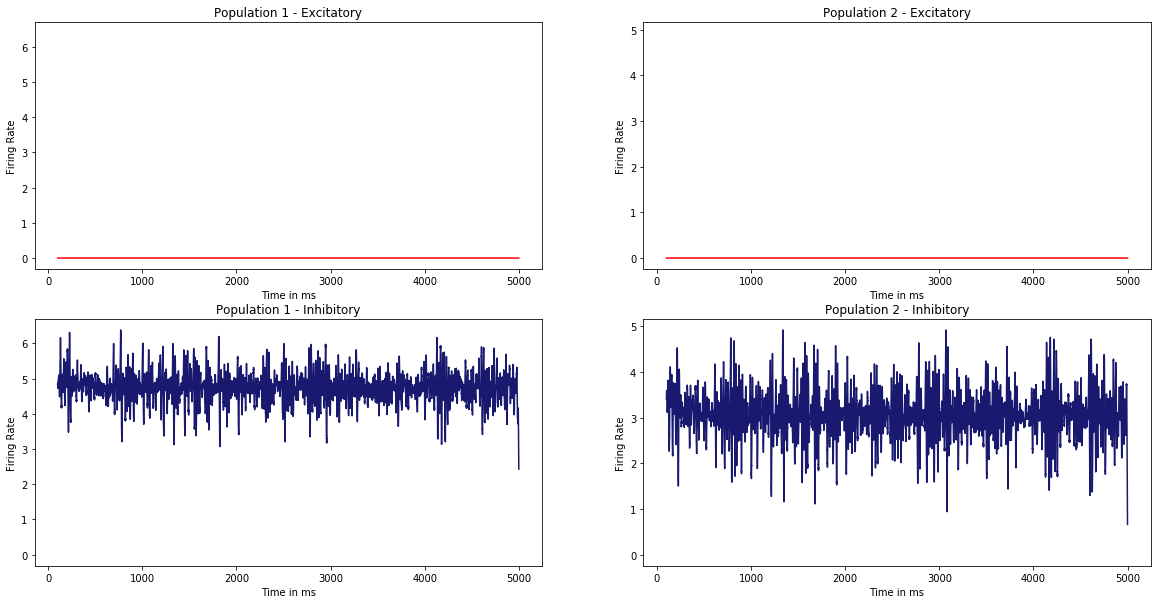

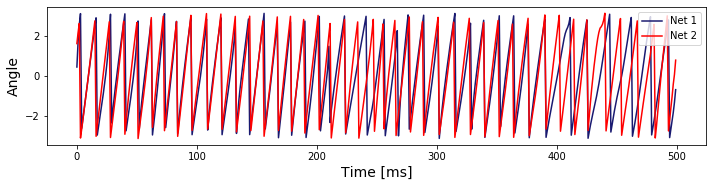

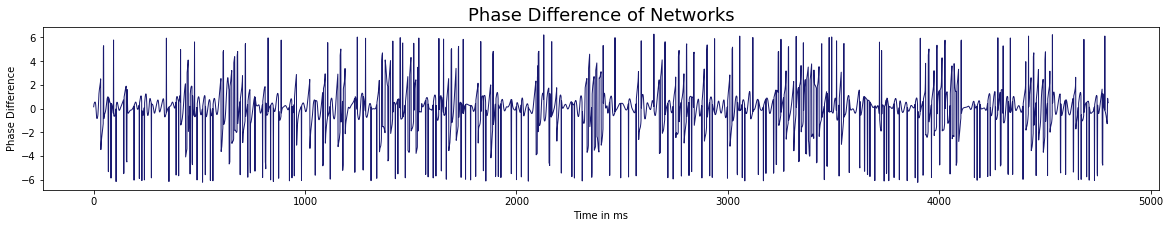

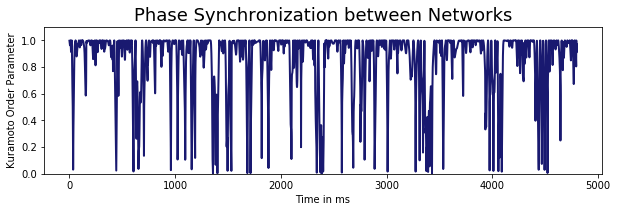

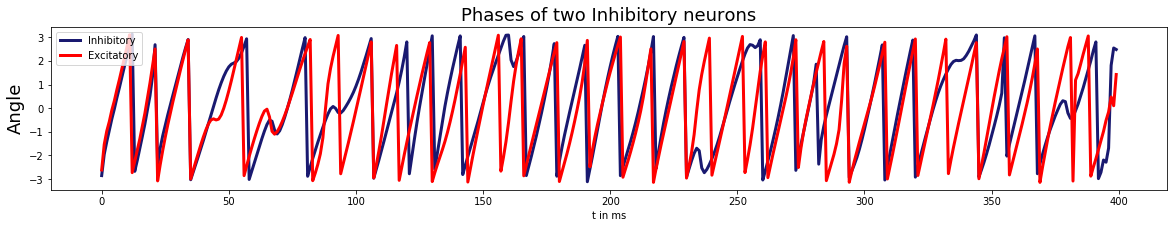

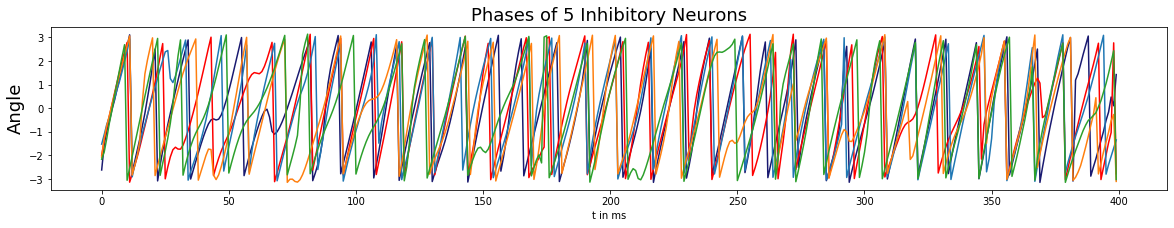

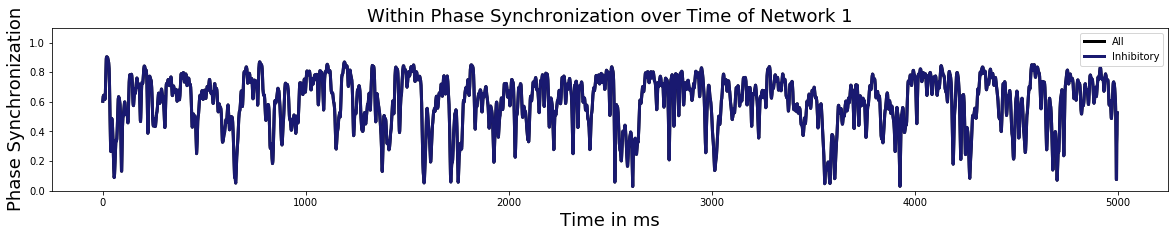

In [22]:
plots.plot_results(model, full_raster=False, psd_group="INH", raster_right=1000, folder="ING_strong_noise", save=True, phase_analysis=True)

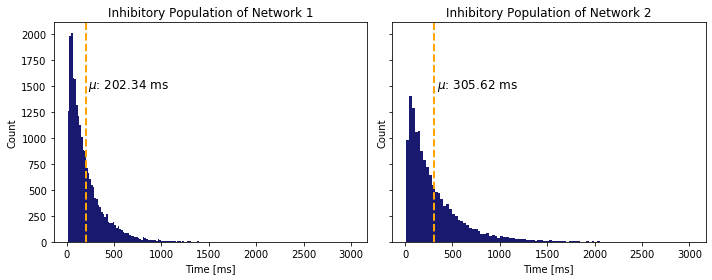

In [32]:
plots.isi_histograms(model, bins=100, folder="ING", key="noise_synch")

#### Spike Variability of I neurons explain synchronization

Only a fraction of neurons participate in each cycle, this allows the slower network 2 to speedend to the frequency of network 1. 

**How?** Once I cells fire in Net 1 inhbition is propagated to Net 2 surpressing a fraction of the I cells. Once inhibitory delay wears of, I cells in net 1 fire again together with the fraction of net 2 that has been surpressed.
However, the other fraction does not fire as they are now surpressed by inhibition.

The increased noise strength increases the membrane voltage heterogenity in both networks, so that the inhibition of I cells in net 1 is significantly more likely to surpress some of the neurons in net 2, while other neurons fire as inhibiton is not strong enough.

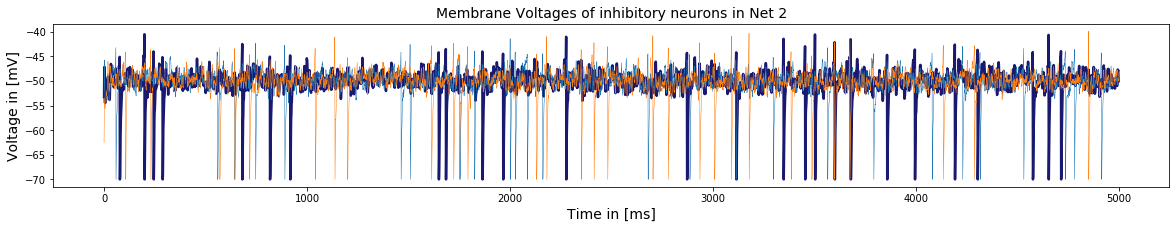

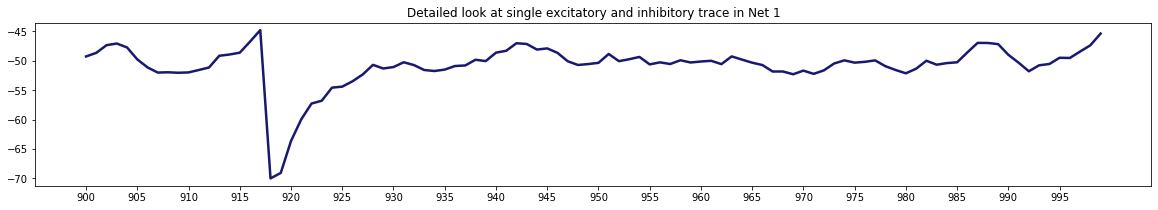

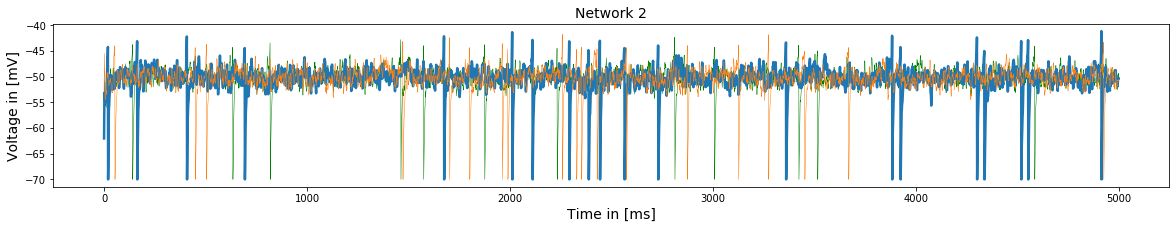

In [70]:
plots.membrane_potentials_sample(model)

-70.0 1865.0
21
979


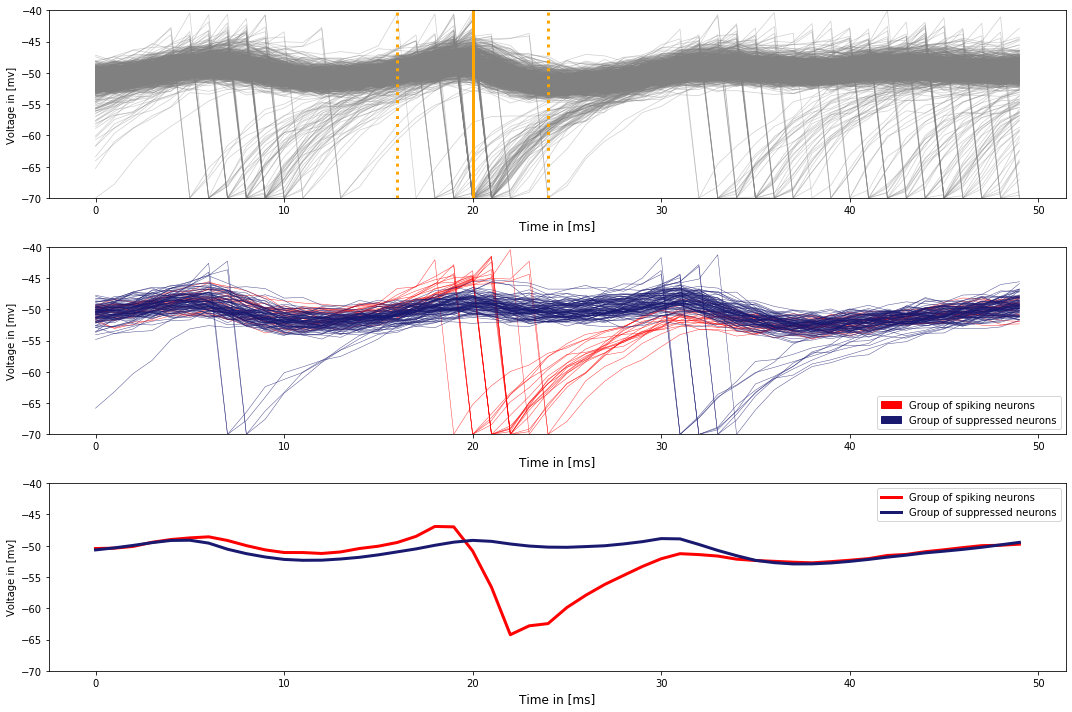

In [117]:
v = model["v_all_neurons_i1"]
v2 = model["v_all_neurons_i2"]
t = model["t_all_neurons_i1"]

# window = (940, 970)
w = (1800, 2000)
v_s, t_s = processing.get_first_spike(v, t, window=w)
print(v_s, t_s)

window = (int(t_s - 20), int(t_s + 30))

plots.spike_variability_analysis(v, v2, window=window, t_s=t_s, t_width=(4, 4), folder="ING", key="noise_synch")

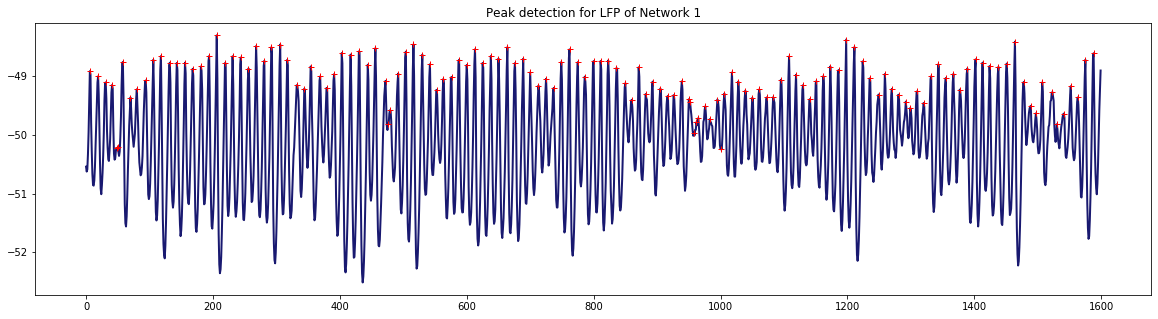

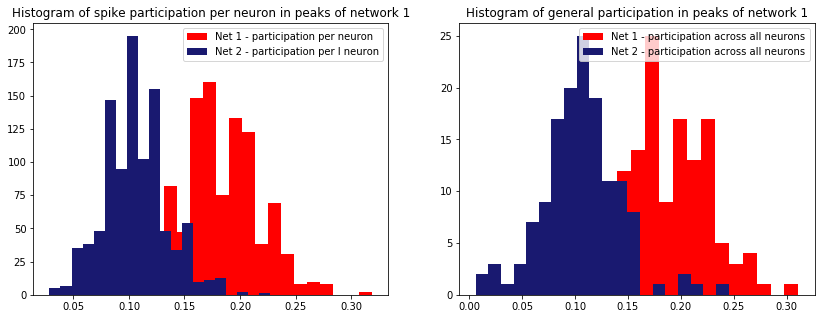

In [33]:
plots.spike_participation_histograms(model)

## Strong Coupling and Strong Noise

Synchronized, maybe a little bit noiser compared to weak noise, but no significant difference.

In [17]:
synch = dict(params)
synch.update({
    "runtime": 1000,
    "poisson_variance": 1.5,
    "poisson_p": 0.84,
    "J_ppii": 0.3,
    "net_record_spikes": 1000,
})

model = runner.run(
    modified_params=synch,
    file_name="ING-str-coupling-str-noise",
    load=True
)

Global Order Parameter value of: 0.9881679107910227
Mean Phase Coherence 0.9878239127594027
Computing within synchronization for network 1 and 2
Within Synchronization of Network 1 0.6904653481500013
Within Synchronization of Network 2 0.7106526163860472


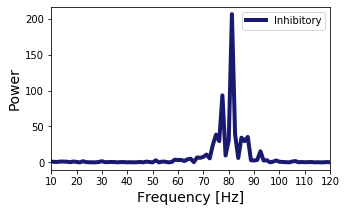

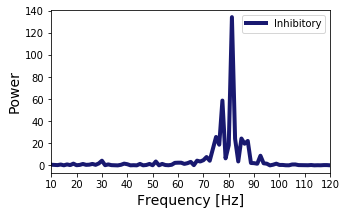

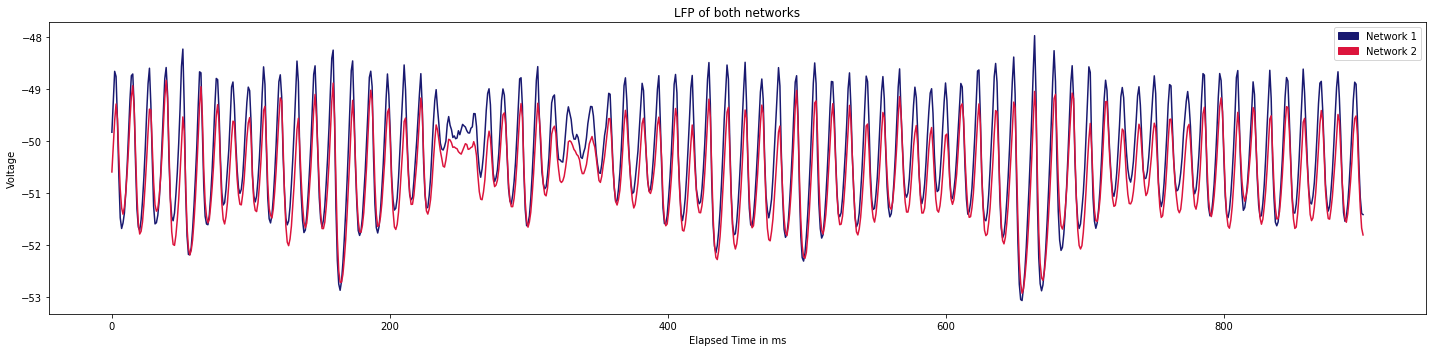

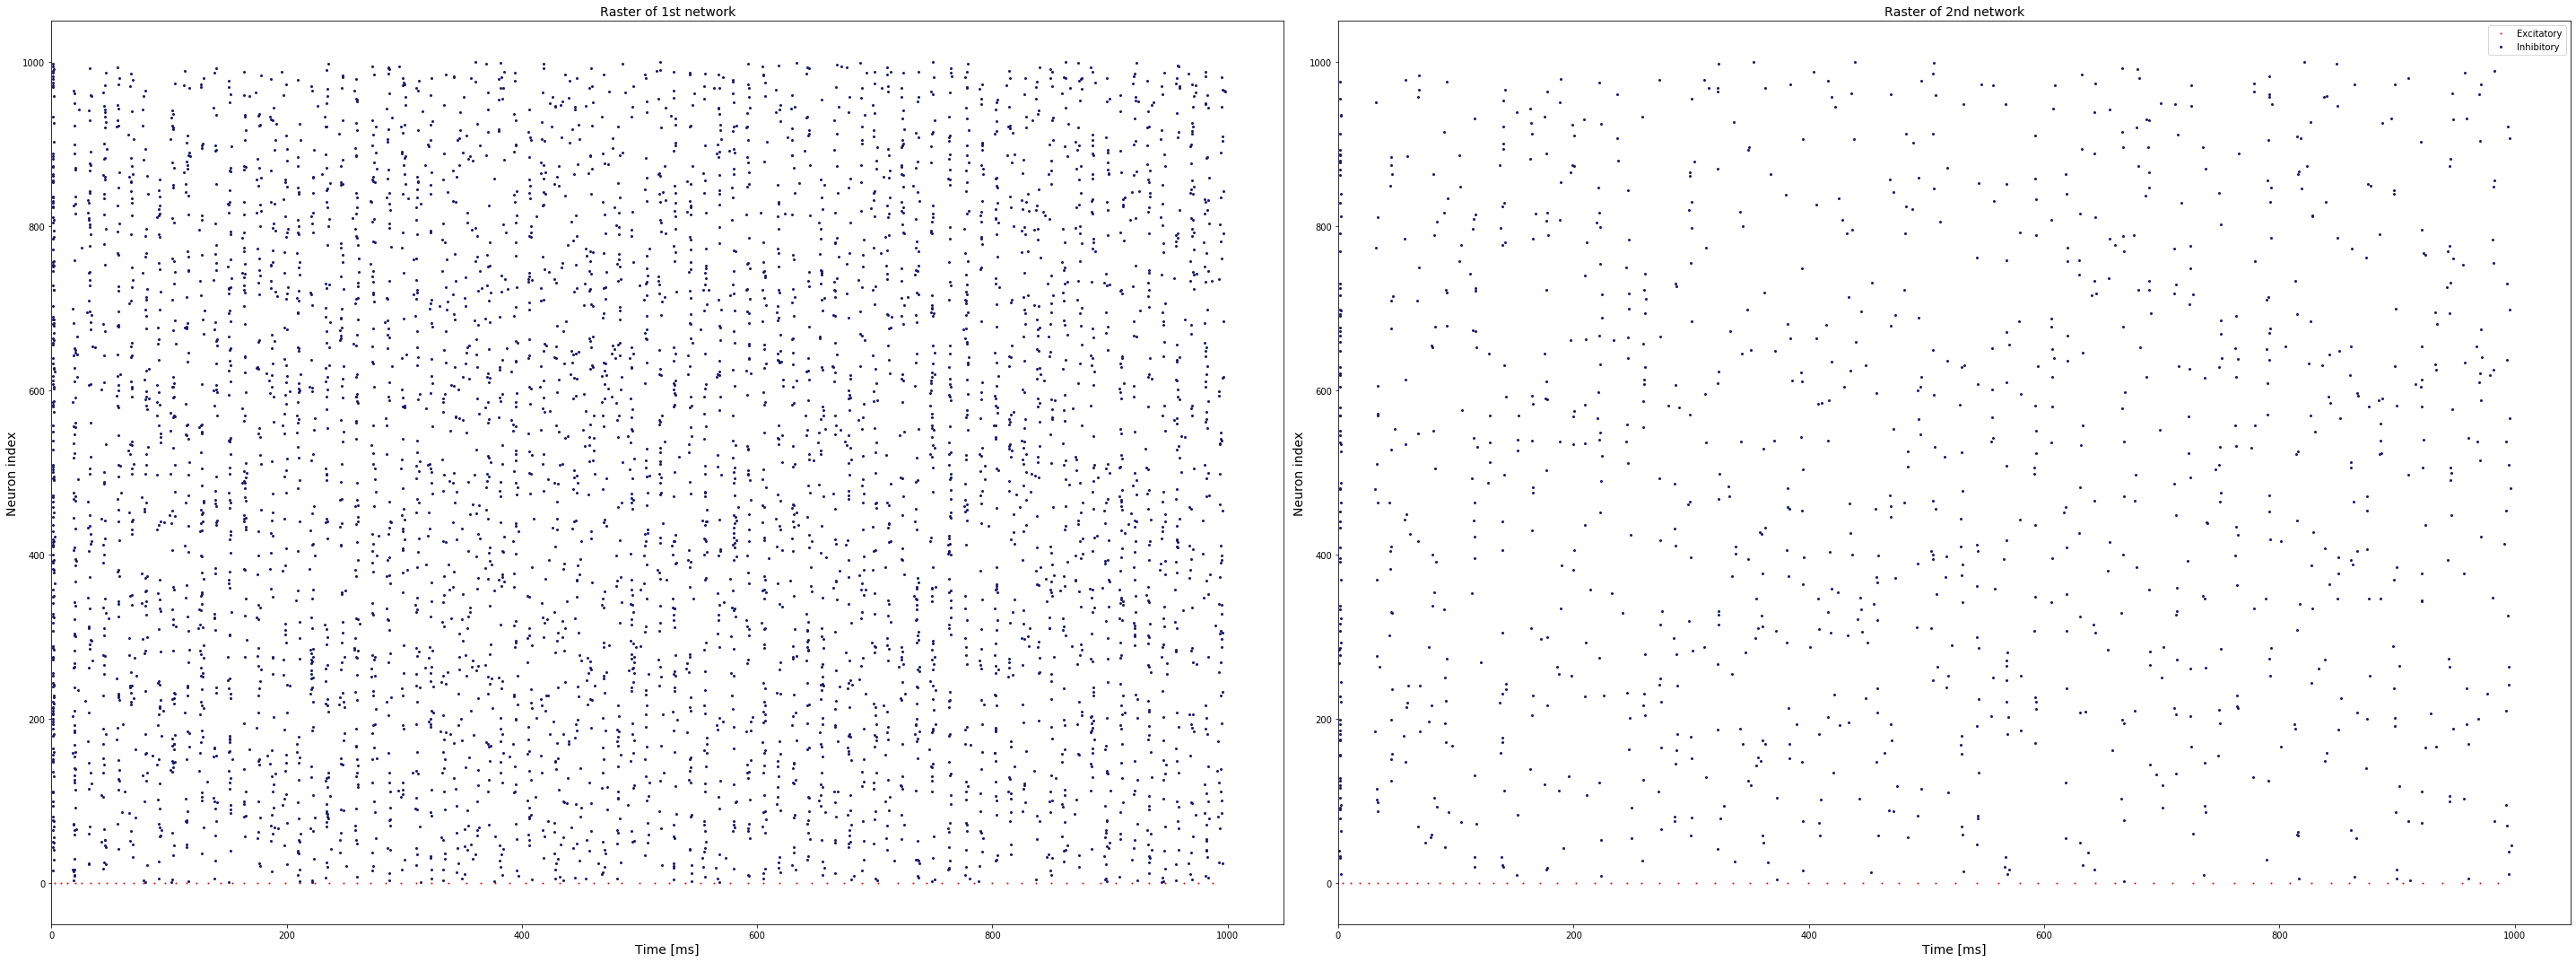

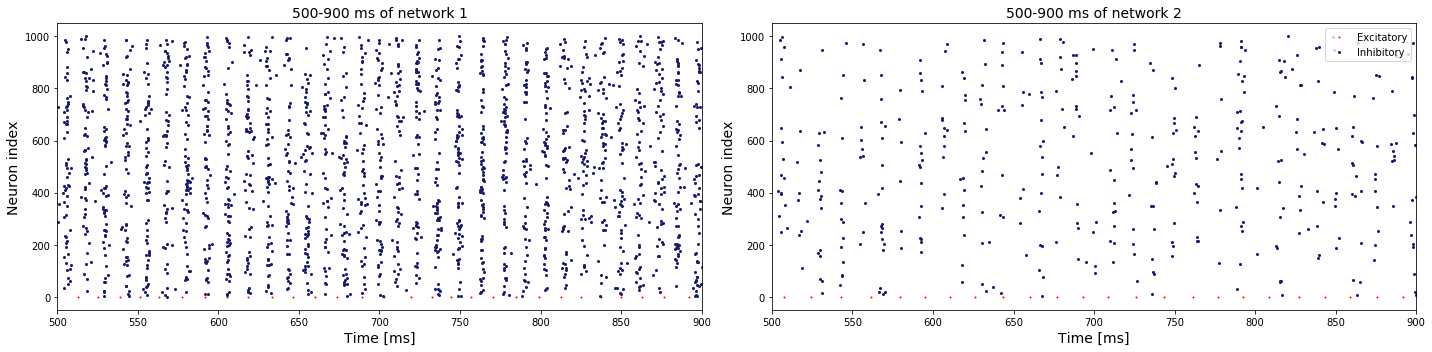

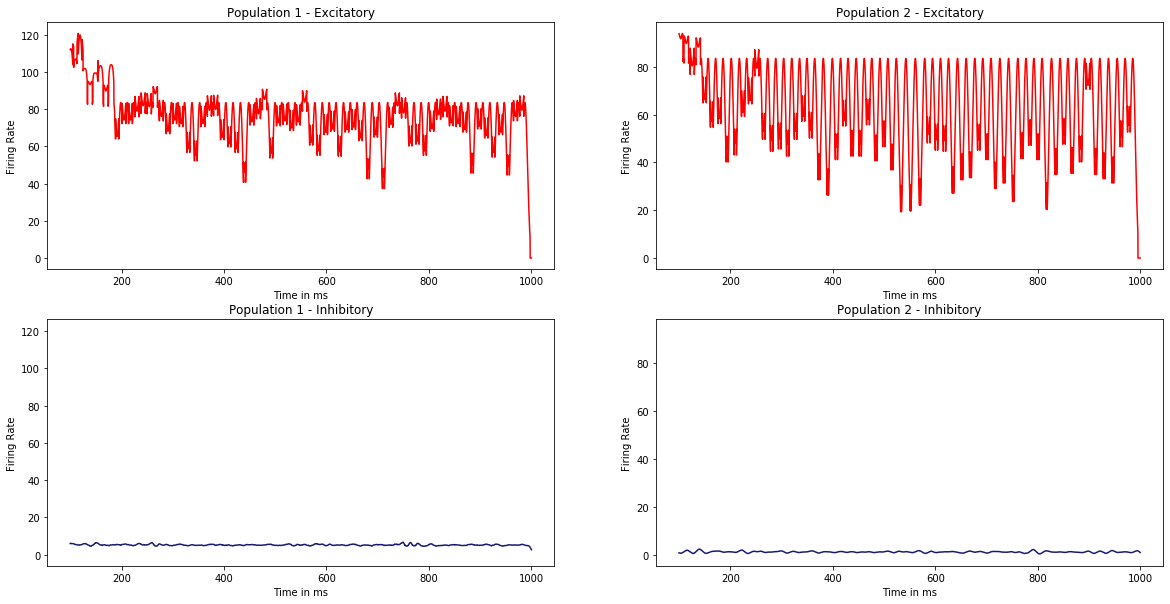

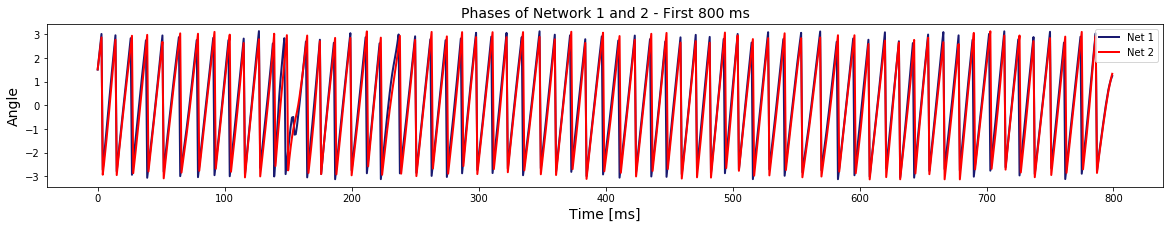

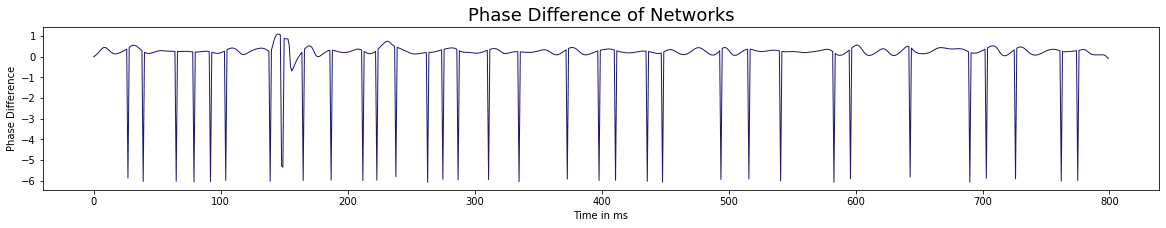

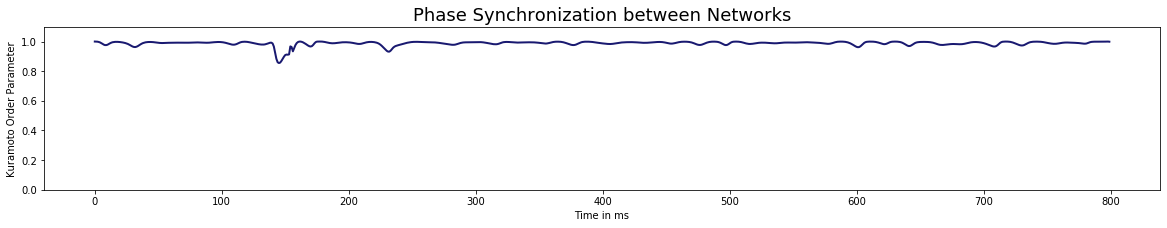

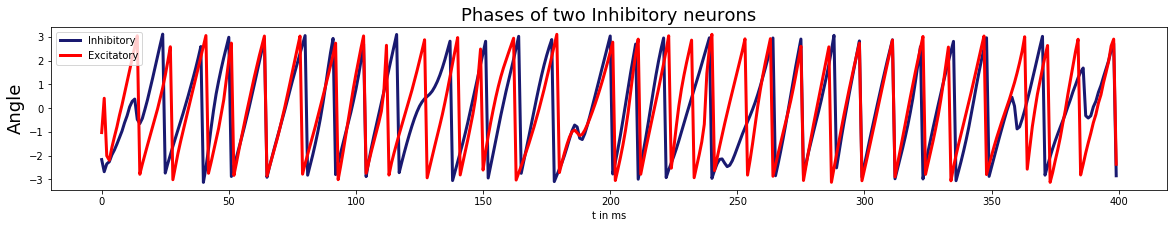

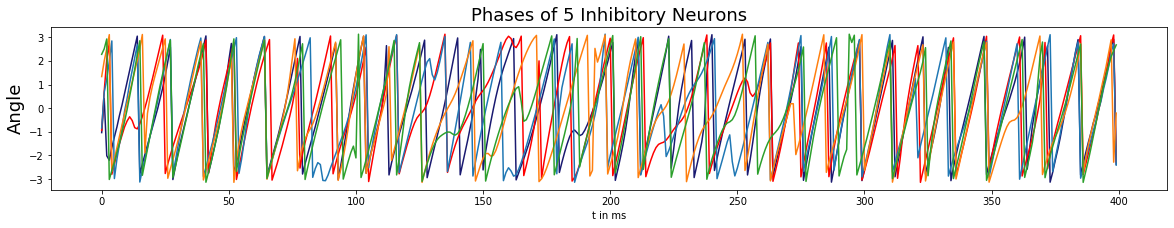

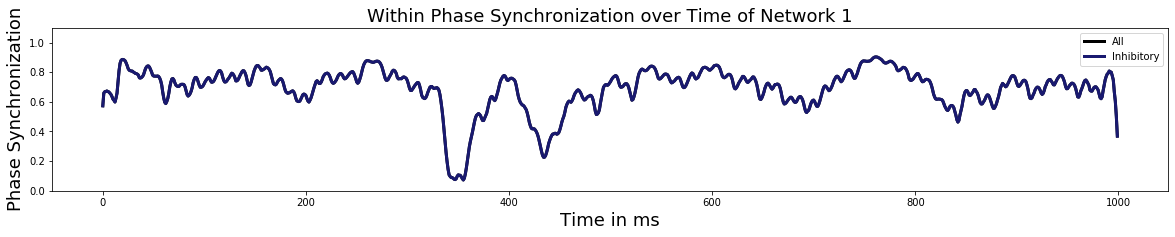

In [9]:
plots.plot_results(model, full_raster=True, psd_group="INH", phase_analysis=True)

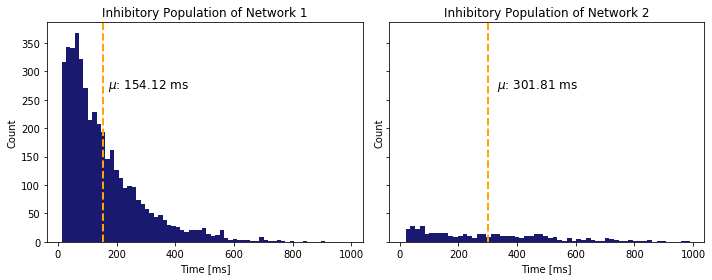

In [18]:
plots.isi_histograms(model, folder="ING", key="coupling-strong", filter_outlier=False)

# Exploration

## Exploration over Noise Strength 1d

In [3]:
exp_params = {
    "poisson_variance": np.arange(0.5, 4.0, 0.1),
}

ov_params = dict(params)
ov_params.update({
    "runtime": 5000.0,
    "const_delay": 0.0,
    "poisson_p": 0.85,
})

ex = mopet.Exploration(
    runner.run_in_mopet, 
    explore_params=exp_params, 
    default_params=ov_params,
    hdf_filename=constants.MODELS_PATH + "/ING_synch_noise_1d.h5",
    # exp_7 is default
    exploration_name="exp_7"
)

In [4]:
ex.run()

2020-09-04 12:27:46,332	INFO resource_spec.py:212 -- Starting Ray with 13.87 GiB memory available for workers and up to 6.95 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-04 12:27:46,565	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-09-04 12:27:46,815	INFO services.py:1165 -- View the Ray dashboard at localhost:8265
INFO:root:Starting 35 jobs.
100%|██████████| 35/35 [00:00<00:00, 988.14it/s]
INFO:root:Runs took 0.039314985275268555 s to submit.
  0%|          | 0/35 [00:00<?, ?it/s]

(pid=14625) Starting simulation at t=0. s for a duration of 5. s
(pid=14628) Starting simulation at t=0. s for a duration of 5. s
(pid=14629) Starting simulation at t=0. s for a duration of 5. s
(pid=14630) Starting simulation at t=0. s for a duration of 5. s
(pid=14624) Starting simulation at t=0. s for a duration of 5. s
(pid=14627) Starting simulation at t=0. s for a duration of 5. s
(pid=14626) Starting simulation at t=0. s for a duration of 5. s
(pid=14623) Starting simulation at t=0. s for a duration of 5. s
(pid=14632) Starting simulation at t=0. s for a duration of 5. s
(pid=14634) Starting simulation at t=0. s for a duration of 5. s
(pid=14633) Starting simulation at t=0. s for a duration of 5. s
(pid=14631) Starting simulation at t=0. s for a duration of 5. s
(pid=14625) 0.5587 s (11%) simulated in 10s, estimated 1m 19s remaining.
(pid=14628) 0.54735 s (10%) simulated in 10s, estimated 1m 21s remaining.
(pid=14629) 0.53625 s (10%) simulated in 10s, estimated 1m 23s remaining.

  3%|▎         | 1/35 [02:56<1:40:17, 176.98s/it]

(pid=14625) Starting simulation at t=0. s for a duration of 5. s


  9%|▊         | 3/35 [02:58<46:26, 87.08s/it]   

(pid=14629) Starting simulation at t=0. s for a duration of 5. s


 20%|██        | 7/35 [03:02<10:15, 22.00s/it]

(pid=14628) Starting simulation at t=0. s for a duration of 5. s


 34%|███▍      | 12/35 [03:05<01:36,  4.20s/it]

(pid=14624) Starting simulation at t=0. s for a duration of 5. s
(pid=14625) 293.75 ms (5%) simulated in 10s, estimated 2m 40s remaining.
(pid=14629) 306. ms (6%) simulated in 10s, estimated 2m 33s remaining.
(pid=14626) Starting simulation at t=0. s for a duration of 5. s
(pid=14632) Starting simulation at t=0. s for a duration of 5. s
(pid=14627) Starting simulation at t=0. s for a duration of 5. s
(pid=14628) 304.75 ms (6%) simulated in 10s, estimated 2m 34s remaining.
(pid=14634) Starting simulation at t=0. s for a duration of 5. s
(pid=14624) 300.05 ms (6%) simulated in 10s, estimated 2m 37s remaining.
(pid=14633) Starting simulation at t=0. s for a duration of 5. s
(pid=14625) 0.5978 s (11%) simulated in 20s, estimated 2m 27s remaining.
(pid=14630) Starting simulation at t=0. s for a duration of 5. s
(pid=14629) 0.62235 s (12%) simulated in 20s, estimated 2m 21s remaining.
(pid=14626) 315.35 ms (6%) simulated in 10s, estimated 2m 29s remaining.
(pid=14632) 0.3278 s (6%) simulated

 37%|███▋      | 13/35 [05:21<16:02, 43.76s/it]

(pid=14632) 5. s (100%) simulated in 2m 11s
(pid=14623) 4.696 s (93%) simulated in 2m 0s, estimated 8s remaining.
(pid=14627) 5. s (100%) simulated in 2m 9s
(pid=14627) WARNING    /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:1397: RuntimeWarning: overflow encountered in true_divide
(pid=14627)   result = operation(self_arr, other_arr)
(pid=14627)  [py.warnings]
(pid=14627) WARNING:py.warnings:/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:1397: RuntimeWarning: overflow encountered in true_divide
(pid=14627)   result = operation(self_arr, other_arr)
(pid=14627) 
(pid=14634) 4.9963 s (99%) simulated in 2m 10s, estimated < 1s remaining.
(pid=14631) 4.7096 s (94%) simulated in 2m 0s, estimated 7s remaining.
(pid=14634) 5. s (100%) simulated in 2m 10s
(pid=14634) WARNING    /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/ven

 40%|████      | 14/35 [05:27<11:16, 32.23s/it]

(pid=14630) 4.9697 s (99%) simulated in 2m 10s, estimated 1s remaining.


 43%|████▎     | 15/35 [05:27<07:33, 22.69s/it]

(pid=14630) 5. s (100%) simulated in 2m 10s
(pid=14630) WARNING    /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:1397: RuntimeWarning: overflow encountered in true_divide
(pid=14630)   result = operation(self_arr, other_arr)
(pid=14630)  [py.warnings]
(pid=14630) WARNING:py.warnings:/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:1397: RuntimeWarning: overflow encountered in true_divide
(pid=14630)   result = operation(self_arr, other_arr)
(pid=14630) 


 46%|████▌     | 16/35 [05:28<05:05, 16.09s/it]

(pid=14623) 5. s (100%) simulated in 2m 7s
(pid=14631) 5. s (100%) simulated in 2m 7s
(pid=14625) Starting simulation at t=0. s for a duration of 5. s
(pid=14629) Starting simulation at t=0. s for a duration of 5. s


 51%|█████▏    | 18/35 [05:38<02:50, 10.04s/it]

(pid=14624) Starting simulation at t=0. s for a duration of 5. s


 63%|██████▎   | 22/35 [05:40<00:36,  2.80s/it]

(pid=14626) Starting simulation at t=0. s for a duration of 5. s


 66%|██████▌   | 23/35 [05:42<00:30,  2.56s/it]

(pid=14625) 0.38385 s (7%) simulated in 10s, estimated 2m 0s remaining.


 69%|██████▊   | 24/35 [05:43<00:21,  1.92s/it]

(pid=14629) 0.3824 s (7%) simulated in 10s, estimated 2m 1s remaining.
(pid=14632) Starting simulation at t=0. s for a duration of 5. s
(pid=14634) Starting simulation at t=0. s for a duration of 5. s
(pid=14628) Starting simulation at t=0. s for a duration of 5. s
(pid=14627) Starting simulation at t=0. s for a duration of 5. s
(pid=14624) 0.37585 s (7%) simulated in 10s, estimated 2m 3s remaining.
(pid=14630) Starting simulation at t=0. s for a duration of 5. s
(pid=14626) 0.37785 s (7%) simulated in 10s, estimated 2m 2s remaining.
(pid=14633) Starting simulation at t=0. s for a duration of 5. s
(pid=14625) 0.75695 s (15%) simulated in 20s, estimated 1m 52s remaining.
(pid=14629) 0.7585 s (15%) simulated in 20s, estimated 1m 52s remaining.
(pid=14632) 0.3683 s (7%) simulated in 10s, estimated 2m 6s remaining.
(pid=14623) Starting simulation at t=0. s for a duration of 5. s
(pid=14634) 0.3691 s (7%) simulated in 10s, estimated 2m 5s remaining.
(pid=14628) 0.35865 s (7%) simulated in 1

 74%|███████▍  | 26/35 [08:01<04:30, 30.03s/it]

(pid=14633) 4.68595 s (93%) simulated in 2m 10s, estimated 9s remaining.
(pid=14632) 5. s (100%) simulated in 2m 19s
(pid=14634) 5. s (100%) simulated in 2m 17s
(pid=14623) 4.7598 s (95%) simulated in 2m 10s, estimated 7s remaining.
(pid=14627) 5. s (100%) simulated in 2m 18s
(pid=14628) 4.97705 s (99%) simulated in 2m 20s, estimated 1s remaining.
(pid=14628) 5. s (100%) simulated in 2m 20s
(pid=14630) 5. s (100%) simulated in 2m 18s
(pid=14633) 5. s (100%) simulated in 2m 17s
(pid=14633) WARNING    /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:1397: RuntimeWarning: overflow encountered in true_divide
(pid=14633)   result = operation(self_arr, other_arr)
(pid=14633)  [py.warnings]
(pid=14633) WARNING:py.warnings:/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:1397: RuntimeWarning: overflow encountered in true_divide
(pid=14633)   re

100%|██████████| 35/35 [08:19<00:00, 14.26s/it]
INFO:root:Runs and storage took 499.0815999507904 s to complete.


In [4]:
ex.load_results(all=True)

INFO:root:/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models/ING_synch_noise_1d.h5 opened for reading.
INFO:root:Gettings runs of exploration ``exp_7``
100%|██████████| 35/35 [00:05<00:00,  6.66it/s]
INFO:root:Creating new results DataFrame
INFO:root:Aggregating scalar results ...
100%|██████████| 35/35 [00:05<00:00,  6.60it/s]
INFO:root:/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models/ING_synch_noise_1d.h5 closed.


### Results

{'J_etoe': 0.0,
 'J_etoi': 0.0,
 'J_itoe': 0.0,
 'J_itoi': 0.4,
 'J_ppee': 0.0,
 'J_ppei': 0.0,
 'J_ppii': 0.15,
 'N_e': 1,
 'N_i': 1000,
 'N_pop': 2,
 'const_delay': 0.0,
 'model_EI': False,
 'net_record_spikes': 200,
 'ou_enabled': [False, False],
 'p_etoe': 0,
 'p_etoi': 0.0,
 'p_itoe': 0.0,
 'p_itoi': 1.0,
 'p_ppee': 0.0,
 'p_ppei': 0.0,
 'p_ppii': 1.0,
 'poisson_I_enabled': True,
 'poisson_I_ratio': 1.0,
 'poisson_enabled': [True, True],
 'poisson_mean_input': 300,
 'poisson_p': 0.85,
 'poisson_size': 800,
 'poisson_variance': 0.5,
 'runtime': 5000.0,
 'syn_net_exc': False,
 'syn_net_inh': True,
 'tau_GABA': 20.0}


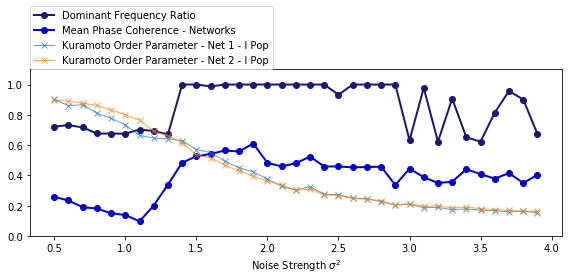

In [7]:
import pprint

plots.plot_exploration(ex, vmin_ratio=None, vmin_phase=None, vmax_phase=None, folder="ING")
pprint.pprint(ex.default_params)

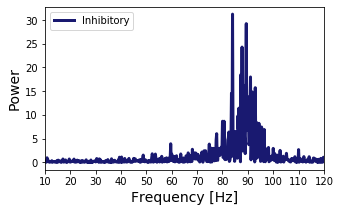

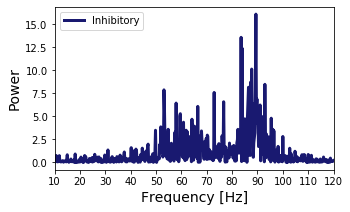

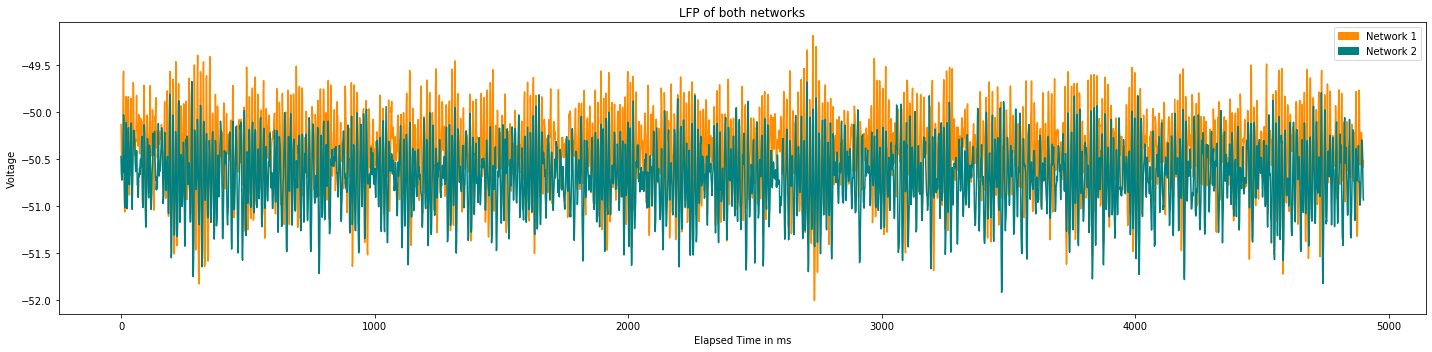

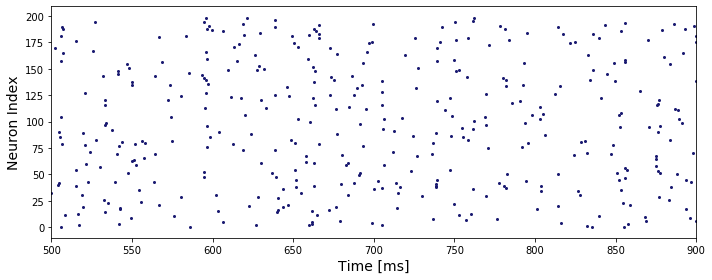

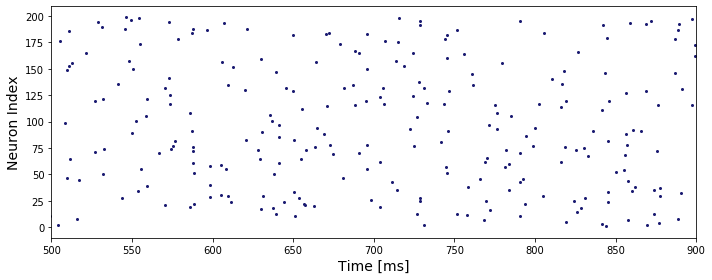

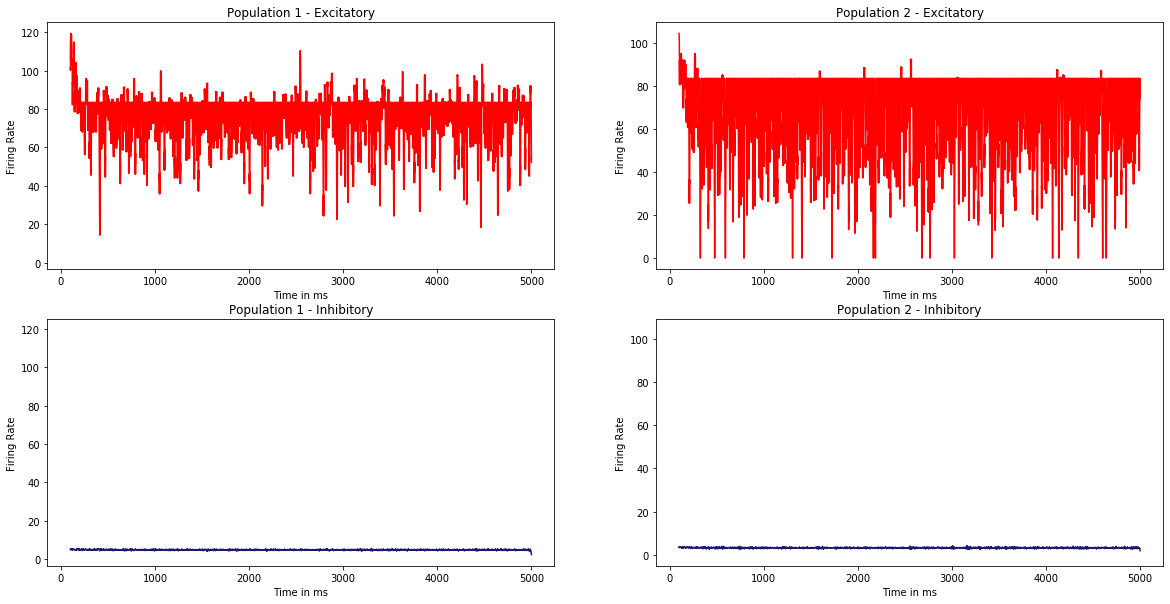

In [35]:
plots.plot_results(ex.get_run(20), psd_group="INH")

In [7]:
ex.params

{0: {'poisson_variance': 0.5},
 1: {'poisson_variance': 1.5},
 10: {'poisson_variance': 10.5},
 11: {'poisson_variance': 11.5},
 12: {'poisson_variance': 12.5},
 13: {'poisson_variance': 13.5},
 14: {'poisson_variance': 14.5},
 2: {'poisson_variance': 2.5},
 3: {'poisson_variance': 3.5},
 4: {'poisson_variance': 4.5},
 5: {'poisson_variance': 5.5},
 6: {'poisson_variance': 6.5},
 7: {'poisson_variance': 7.5},
 8: {'poisson_variance': 8.5},
 9: {'poisson_variance': 9.5}}

Global Order Parameter value of: 0.6701596759795648
Mean Phase Coherence 0.12356346574053309
Computing within synchronization for network 1 and 2
Within Synchronization of Network 1 0.6929046283195431
Within Synchronization of Network 2 0.7694923329836036


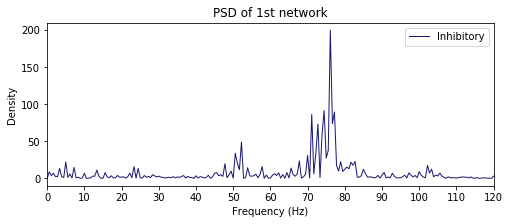

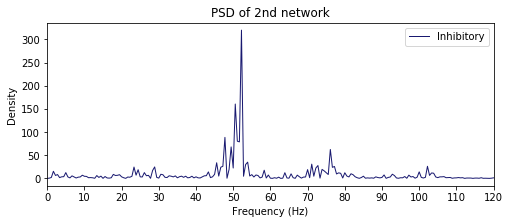

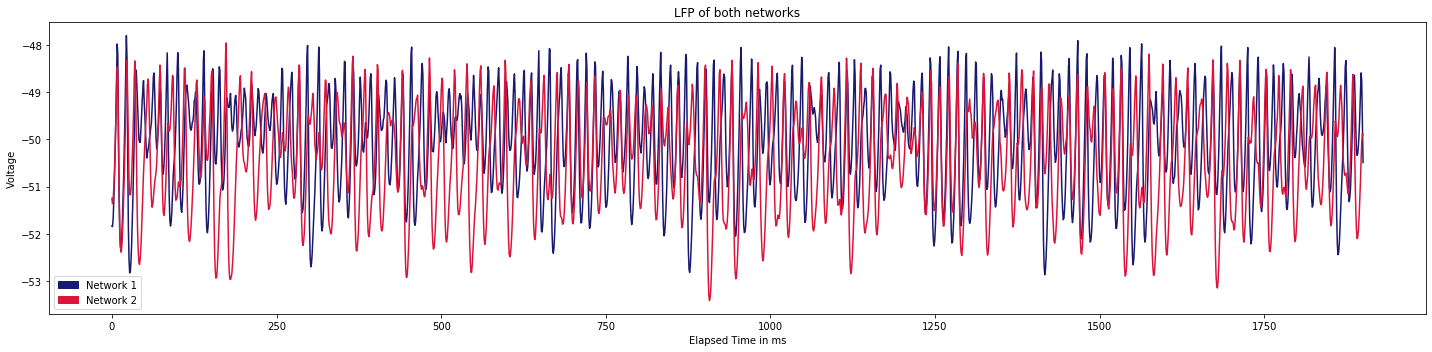

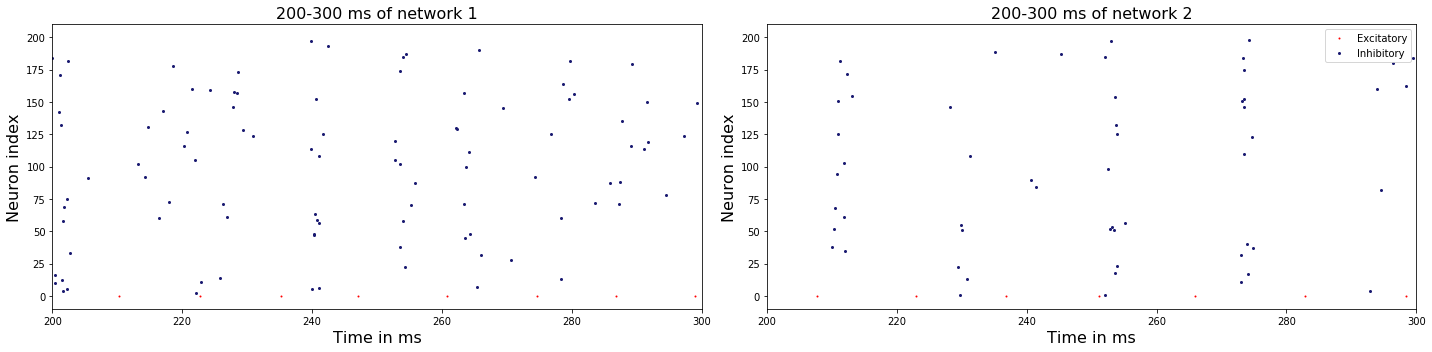

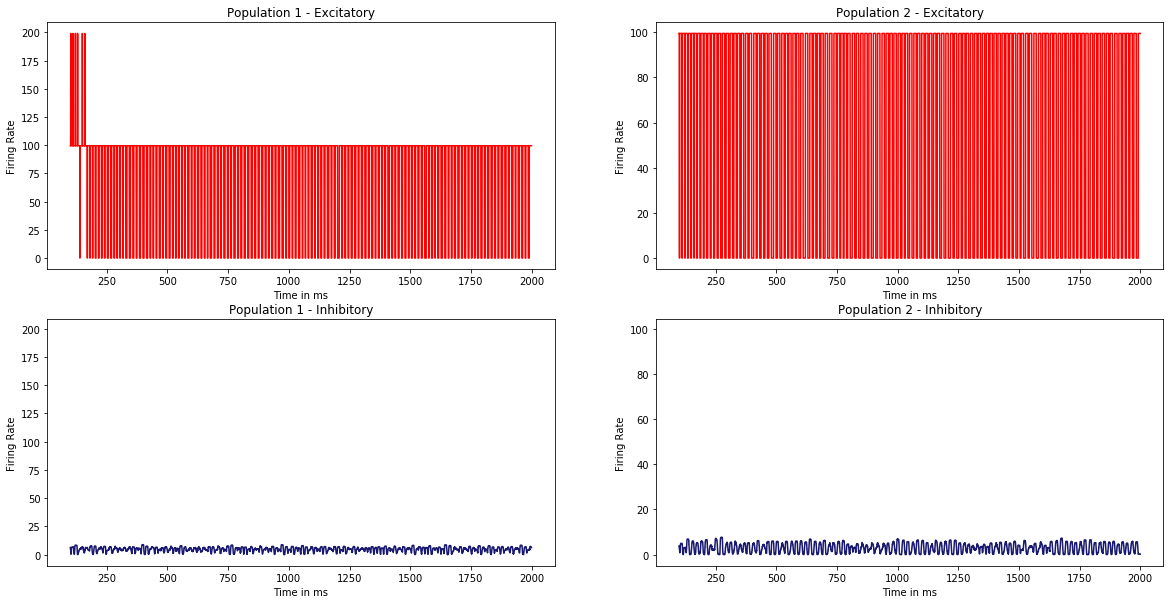

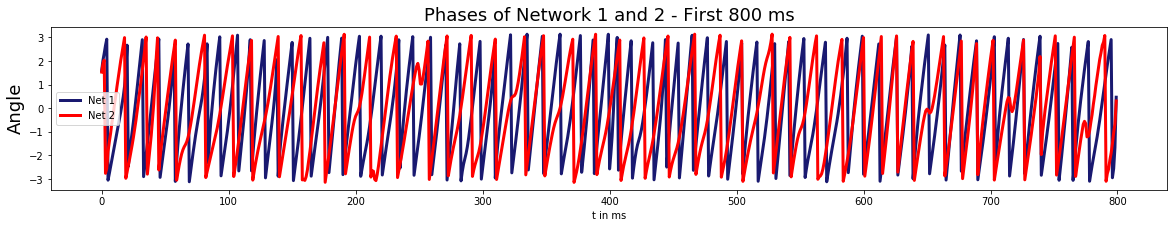

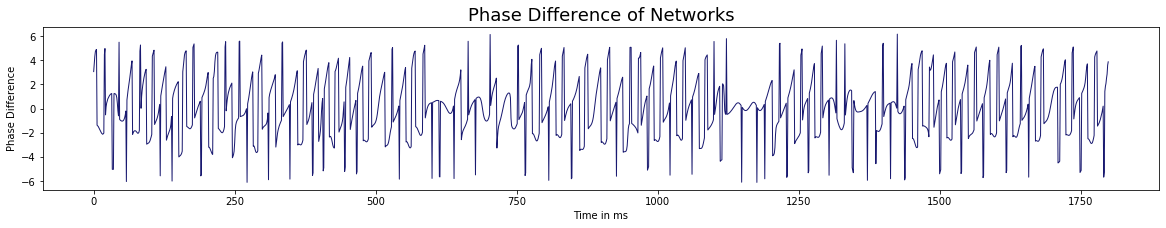

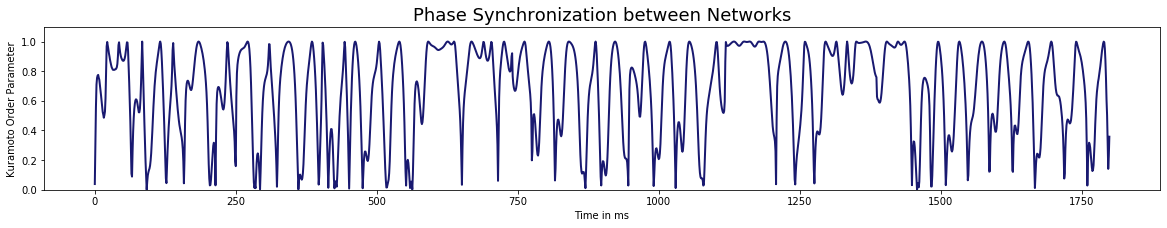

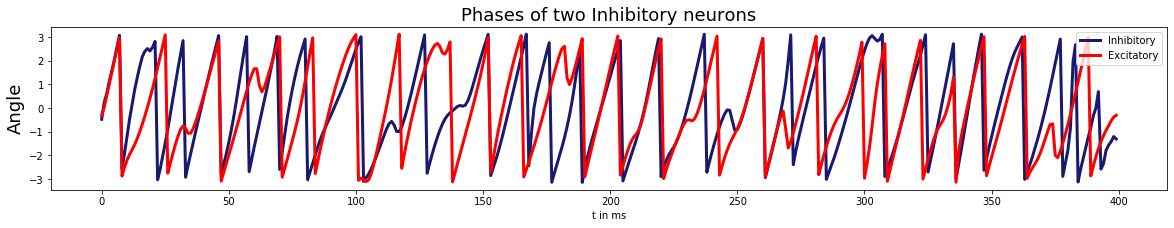

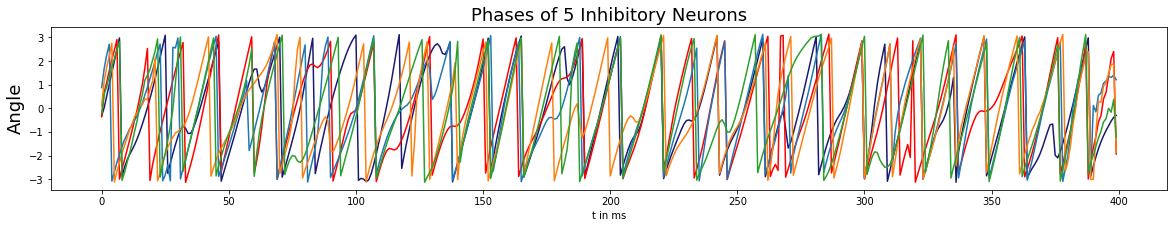

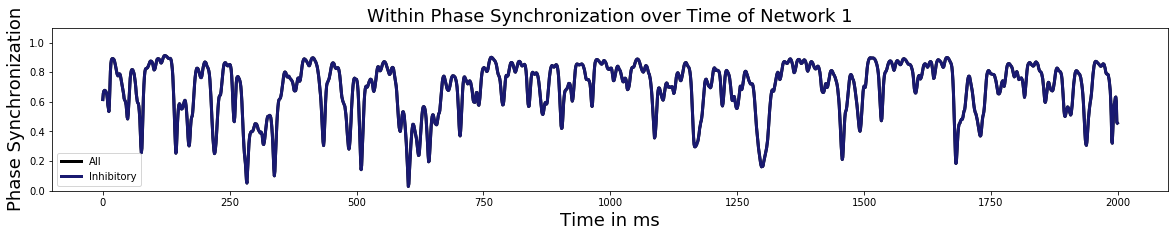

In [112]:
plots.plot_results(ex.get_run(6), psd_group="INH")

## Exploration over Noise Strength and Ratio (2d)

In [3]:
exp_params = {
    "poisson_variance": np.arange(0.5, 4.0, 0.1),
    "poisson_p": np.arange(0.7, 1.0, 0.05),
}

ov_params = dict(params)
ov_params.update({
    "runtime": 3000.0,
    "const_delay": 0.0
})

# 3
ex = mopet.Exploration(
    runner.run_in_mopet, 
    explore_params=exp_params, 
    default_params=ov_params,
    hdf_filename=constants.MODELS_PATH + "/ING_synch_noise.h5",
    exploration_name="exp_05_10"
)

In [4]:
ex.run()

2020-10-05 17:07:22,422	INFO resource_spec.py:212 -- Starting Ray with 10.84 GiB memory available for workers and up to 5.44 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-10-05 17:07:22,645	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-10-05 17:07:22,879	INFO services.py:1165 -- View the Ray dashboard at localhost:8265
INFO:root:Starting 245 jobs.
100%|██████████| 245/245 [00:00<00:00, 305.19it/s]
INFO:root:Runs took 0.8157839775085449 s to submit.
  0%|          | 0/245 [00:00<?, ?it/s]

(pid=24499) Starting simulation at t=0. s for a duration of 3. s
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) 0.4665 s (15%) simulated in 10s, estimated 54s remaining.
(pid=24494) 0.41605 s (13%) simulated in 10s, estimated 1m 2s remaining.
(pid=24501) 0.4093 s (13%) simulated in 10s, estimated 1m 3s remaining.
(pid=

  3%|▎         | 7/245 [02:07<59:15, 14.94s/it]   

(pid=24499) Starting simulation at t=0. s for a duration of 3. s


  5%|▍         | 12/245 [02:10<11:36,  2.99s/it]

(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) 0.3226 s (10%) simulated in 10s, estimated 1m 23s remaining.
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) 291.95 ms (9%) simulated in 10s, estimated 1m 33s remaining.
(pid=24500) 290.45 ms (9%) simulated in 10s, estimated 1m 33s remaining.
(pid=24502) 286.4 ms (9%) simulated in 10s, estimated 1m 35s remai

  5%|▌         | 13/245 [03:37<1:49:38, 28.36s/it]

(pid=24493) 2.977 s (99%) simulated in 1m 20s, estimated 1s remaining.
(pid=24497) 2.8386 s (94%) simulated in 1m 20s, estimated 5s remaining.
(pid=24496) 3. s (100%) simulated in 1m 22s
(pid=24498) 2.8475 s (94%) simulated in 1m 20s, estimated 4s remaining.
(pid=24494) 3. s (100%) simulated in 1m 22s
(pid=24493) 3. s (100%) simulated in 1m 20s
(pid=24495) 2.8278 s (94%) simulated in 1m 20s, estimated 5s remaining.
(pid=24503) 3. s (100%) simulated in 1m 23s
(pid=24501) 3. s (100%) simulated in 1m 25s
(pid=24498) 3. s (100%) simulated in 1m 24s
(pid=24497) 3. s (100%) simulated in 1m 24s
(pid=24497) WARNING    /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:1397: RuntimeWarning: overflow encountered in true_divide
(pid=24497)   result = operation(self_arr, other_arr)
(pid=24497)  [py.warnings]
(pid=24497) WARNING:py.warnings:/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-pac

  9%|▊         | 21/245 [03:50<08:21,  2.24s/it]  

(pid=24499) Starting simulation at t=0. s for a duration of 3. s


 10%|▉         | 24/245 [03:52<04:31,  1.23s/it]

(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) 0.38745 s (12%) simulated in 10s, estimated 1m 7s remaining.
(pid=24500) 0.39605 s (13%) simulated in 10s, estimated 1m 6s remaining.
(pid=24502) 0.39415 s (13%) simulated in 10s, estimated 1m 6s remaining.
(pid=24504) 0.3806 s (12%) simulated in 10s, estimated 1m 9s remaining.
(pid=24495) Starting simulation at t=0. s for a duration of

 11%|█         | 26/245 [05:18<1:08:25, 18.75s/it]

(pid=24503) 3. s (100%) simulated in 1m 19s
(pid=24497) 2.9431 s (98%) simulated in 1m 20s, estimated 2s remaining.


 11%|█         | 27/245 [05:19<48:04, 13.23s/it]  

(pid=24501) 2.96685 s (98%) simulated in 1m 20s, estimated 1s remaining.
(pid=24498) 3. s (100%) simulated in 1m 19s
(pid=24496) 2.9967 s (99%) simulated in 1m 20s, estimated < 1s remaining.
(pid=24496) 3. s (100%) simulated in 1m 20s
(pid=24496) WARNING    /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:1397: RuntimeWarning: overflow encountered in true_divide
(pid=24496)   result = operation(self_arr, other_arr)
(pid=24496)  [py.warnings]
(pid=24496) WARNING:py.warnings:/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:1397: RuntimeWarning: overflow encountered in true_divide
(pid=24496)   result = operation(self_arr, other_arr)
(pid=24496) 
(pid=24493) 2.9891 s (99%) simulated in 1m 20s, estimated < 1s remaining.
(pid=24494) 2.98295 s (99%) simulated in 1m 20s, estimated < 1s remaining.
(pid=24493) 3. s (100%) simulated in 1m 20s
(pi

 11%|█▏        | 28/245 [05:20<35:06,  9.71s/it]

(pid=24497) 3. s (100%) simulated in 1m 21s
(pid=24495) 2.9158 s (97%) simulated in 1m 20s, estimated 2s remaining.
(pid=24495) 3. s (100%) simulated in 1m 22s


 14%|█▍        | 35/245 [05:31<05:11,  1.48s/it]

(pid=24499) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) Starting simulation at t=0. s for a duration of 3. s


 15%|█▍        | 36/245 [05:36<08:38,  2.48s/it]

(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) 0.35195 s (11%) simulated in 10s, estimated 1m 15s remaining.
(pid=24504) 0.34045 s (11%) simulated in 10s, estimated 1m 18s remaining.
(pid=24500) 0.34855 s (11%) simulated in 10s, estimated 1m 16s remaining.
(pid=24502) 0.35535 s (11%) simulated in 10s, estimated 1m 14s remaining.
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) 0.3441 s (11%) simulated in 10s, estimated 1m 17s remaining.
(pid=24498) 0.33115 s (11%) simulated in 10s, estimated 1m 21s remaining.
(pid=24497) 0.3685 s (12%) simulated in 10s, estimated 1m 11s remaining.
(pid=24501) 0.36785 s (12%) s

 16%|█▌        | 38/245 [06:55<1:01:37, 17.86s/it]

(pid=24493) WARNING    /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:1397: RuntimeWarning: overflow encountered in true_divide
(pid=24493)   result = operation(self_arr, other_arr)
(pid=24493)  [py.warnings]
(pid=24493) WARNING:py.warnings:/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:1397: RuntimeWarning: overflow encountered in true_divide
(pid=24493)   result = operation(self_arr, other_arr)
(pid=24493) 
(pid=24493) 3. s (100%) simulated in 1m 13s
(pid=24496) 3. s (100%) simulated in 1m 14s


 16%|█▌        | 39/245 [06:55<43:35, 12.69s/it]  

(pid=24497) 3. s (100%) simulated in 1m 15s
(pid=24501) 3. s (100%) simulated in 1m 14s
(pid=24494) WARNING    /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:1397: RuntimeWarning: overflow encountered in true_divide
(pid=24494)   result = operation(self_arr, other_arr)
(pid=24494)  [py.warnings]
(pid=24494) WARNING:py.warnings:/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:1397: RuntimeWarning: overflow encountered in true_divide
(pid=24494)   result = operation(self_arr, other_arr)
(pid=24494) 
(pid=24494) 3. s (100%) simulated in 1m 14s


 17%|█▋        | 41/245 [06:58<23:20,  6.87s/it]

(pid=24495) 3. s (100%) simulated in 1m 14s


 19%|█▉        | 47/245 [07:04<04:26,  1.35s/it]

(pid=24500) Starting simulation at t=0. s for a duration of 3. s


 20%|█▉        | 48/245 [07:06<04:59,  1.52s/it]

(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) 0.43745 s (14%) simulated in 10s, estimated 59s remaining.
(pid=24503) 0.43305 s (14%) simulated in 10s, estimated 59s remaining.
(pid=24499) 0.43175 s (14%) simulated in 10s, estimated 59s remaining.
(pid=24504) 0.42435 s (14%) simulated in 10s, estimated 1m 1s remaining.

 20%|██        | 50/245 [08:24<55:47, 17.17s/it]  

(pid=24497) 3. s (100%) simulated in 1m 10s
(pid=24501) 3. s (100%) simulated in 1m 11s


 21%|██        | 51/245 [08:24<39:08, 12.11s/it]

(pid=24495) 3. s (100%) simulated in 1m 10s
(pid=24494) 3. s (100%) simulated in 1m 11s


 22%|██▏       | 55/245 [08:29<13:24,  4.23s/it]

(pid=24499) Starting simulation at t=0. s for a duration of 3. s


 24%|██▍       | 60/245 [08:32<03:14,  1.05s/it]

(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) 0.4196 s (13%) simulated in 10s, estimated 1m 2s remaining.
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) 0.43205 s (14%) simulated in 10s, estimated 59s remaining.
(pid=24502) 0.43285 s (14%) simulated in 10s, estimated 59s remaining.
(pid=24500) 0.42675 s (14%) simulated in 10s, estimated 1m 0s remaining

 26%|██▌       | 63/245 [09:52<37:21, 12.32s/it]  

(pid=24494) 3. s (100%) simulated in 1m 11s


 27%|██▋       | 67/245 [09:54<09:32,  3.22s/it]

(pid=24499) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) Starting simulation at t=0. s for a duration of 3. s


 28%|██▊       | 68/245 [09:59<10:54,  3.70s/it]

(pid=24504) Starting simulation at t=0. s for a duration of 3. s


 28%|██▊       | 69/245 [09:59<07:51,  2.68s/it]

(pid=24500) Starting simulation at t=0. s for a duration of 3. s


 29%|██▉       | 72/245 [10:00<03:35,  1.25s/it]

(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) 0.4267 s (14%) simulated in 10s, estimated 1m 0s remaining.
(pid=24503) 0.42935 s (14%) simulated in 10s, estimated 1m 0s remaining.
(pid=24502) 0.4218 s (14%) simulated in 10s, estimated 1m 1s remaining.
(pid=24504) 0.41475 s (13%) simulated in 10s, estimated 1m 2s remaining.
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) 0.4245 s (14%) simulated in 10s, estimated 1m 1s remaining.
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) 0.42405 s (14%) simulated in 10s, estimated 1m 1s remaining.
(pid=24497) 0.41925 s (13%) simulated in 10s, estimated 1m 2s remaining.
(pid=24501) 0.41685 s (13%) simulated

 30%|██▉       | 73/245 [11:15<1:06:41, 23.27s/it]

(pid=24501) 3. s (100%) simulated in 1m 11s
(pid=24498) 3. s (100%) simulated in 1m 11s


 31%|███▏      | 77/245 [11:18<17:21,  6.20s/it]  

(pid=24495) 2.94075 s (98%) simulated in 1m 10s, estimated 1s remaining.
(pid=24494) 2.922 s (97%) simulated in 1m 10s, estimated 2s remaining.
(pid=24493) 2.98755 s (99%) simulated in 1m 10s, estimated < 1s remaining.
(pid=24493) 3. s (100%) simulated in 1m 10s
(pid=24495) 3. s (100%) simulated in 1m 11s
(pid=24494) 3. s (100%) simulated in 1m 11s


 33%|███▎      | 81/245 [11:23<05:51,  2.15s/it]

(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) Starting simulation at t=0. s for a duration of 3. s


 34%|███▍      | 83/245 [11:26<05:08,  1.90s/it]

(pid=24496) Starting simulation at t=0. s for a duration of 3. s


 34%|███▍      | 84/245 [11:27<04:10,  1.56s/it]

(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) 0.45855 s (15%) simulated in 10s, estimated 55s remaining.
(pid=24504) 0.4411 s (14%) simulated in 10s, estimated 58s remaining.
(pid=24500) 0.44735 s (14%) simulated in 10s, estimated 57s remaining.
(pid=24499) 0.453 s (15%) simulated in 10s, estimated 56s remaining.
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) 0.45745 s (15%) simulated in 10s, estimated 56s remaining.
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) 0.4417 s (14%) simulated in 10s, estimated 58s remaining.
(pid=24497) 0.4344 s (14%) simulated in 10s, estimated 59s remaining.
(pid=24498) 0.42975 s (14%) simulated in 10s, estimated 1m 0s remaining.
(pid=24501) 0.42715 s (14%) simulated in 10s,

 35%|███▍      | 85/245 [12:42<1:02:39, 23.50s/it]

(pid=24493) 2.95765 s (98%) simulated in 1m 10s, estimated 1s remaining.


 35%|███▌      | 86/245 [12:42<43:52, 16.56s/it]  

(pid=24498) 3. s (100%) simulated in 1m 11s
(pid=24501) 3. s (100%) simulated in 1m 11s


 36%|███▌      | 88/245 [12:43<21:40,  8.29s/it]

(pid=24493) 3. s (100%) simulated in 1m 11s


 36%|███▋      | 89/245 [12:44<15:49,  6.09s/it]

(pid=24494) 2.903 s (96%) simulated in 1m 10s, estimated 2s remaining.


 37%|███▋      | 90/245 [12:46<12:26,  4.82s/it]

(pid=24495) 2.9479 s (98%) simulated in 1m 10s, estimated 1s remaining.


 37%|███▋      | 91/245 [12:47<09:30,  3.71s/it]

(pid=24495) 3. s (100%) simulated in 1m 11s
(pid=24494) 3. s (100%) simulated in 1m 12s


 38%|███▊      | 94/245 [12:50<04:37,  1.84s/it]

(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s


 39%|███▉      | 96/245 [12:55<04:51,  1.95s/it]

(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) 0.4096 s (13%) simulated in 10s, estimated 1m 3s remaining.
(pid=24502) 0.40675 s (13%) simulated in 10s, estimated 1m 4s remaining.
(pid=24496) 0.39955 s (13%) simulated in 10s, estimated 1m 5s remaining.
(pid=24504) 0.39325 s (13%) simulated in 10s, estimated 1m 6s remaining.
(pid=24500) 0.4018 s (13%) simulated in 10s, estimated 1m 5s remaining.
(pid=24499) 0.40145 s (13%) simulated in 10s, estimated 1m 5s remaining.
(pid=24497) 0.38955 s (12%) simulated in 10s, estimated 1m 7s remaining.
(pid=24501) 0.3926 s (13%) simulated in 10s, estimated 1m 6s remaining.
(pid=24498) 0.3938 s (13%) simulated in 10s, estimated 1m 6s remaining.
(pid=24495) 0.40115 s 

 40%|████      | 98/245 [14:11<41:50, 17.07s/it]

(pid=24493) 3. s (100%) simulated in 1m 10s
(pid=24494) 2.91695 s (97%) simulated in 1m 10s, estimated 2s remaining.


 41%|████      | 101/245 [14:13<14:51,  6.19s/it]

(pid=24495) 3. s (100%) simulated in 1m 12s


 42%|████▏     | 102/245 [14:13<10:32,  4.42s/it]

(pid=24494) 3. s (100%) simulated in 1m 12s


 44%|████▍     | 108/245 [14:20<03:24,  1.49s/it]

(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) 0.4485 s (14%) simulated in 10s, estimated 57s remaining.
(pid=24499) 0.4537 s (15%) simulated in 10s, estimated 56s remaining.
(pid=24503) 0.44185 s (14%) simulated in 10s, estimated 58s remaining.
(pid=2450

 45%|████▍     | 110/245 [15:41<40:05, 17.82s/it]

(pid=24495) 3. s (100%) simulated in 1m 13s


 46%|████▌     | 112/245 [15:42<19:43,  8.90s/it]

(pid=24494) 3. s (100%) simulated in 1m 12s


 49%|████▉     | 120/245 [15:49<02:58,  1.43s/it]

(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) 0.45335 s (15%) simulated in 10s, estimated 56s remaining.
(pid=24502) 0.4598 s (15%) simulated in 10s, estimated 55s remaining.
(pid=24500) 0.4573 s (15%) simulated in 10s, estimated 56s remaining.
(pid=2450

 50%|████▉     | 122/245 [17:07<35:26, 17.29s/it]

(pid=24495) 3. s (100%) simulated in 1m 10s


 51%|█████     | 124/245 [17:08<17:24,  8.64s/it]

(pid=24494) 3. s (100%) simulated in 1m 11s


 54%|█████▍    | 132/245 [17:15<02:30,  1.33s/it]

(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) 0.45945 s (15%) simulated in 10s, estimated 55s remaining.
(pid=24504) 0.43815 s (14%) simulated in 10s, estimated 58s remaining.
(pid=24503) 0.4464 s (14%) simulated in 10s, estimated 57s remaining.
(pid=244

 54%|█████▍    | 133/245 [18:42<50:51, 27.25s/it]

(pid=24493) 3. s (100%) simulated in 1m 19s
(pid=24494) 2.9977 s (99%) simulated in 1m 20s, estimated < 1s remaining.
(pid=24494) 3. s (100%) simulated in 1m 20s
(pid=24495) 3. s (100%) simulated in 1m 19s


 59%|█████▉    | 144/245 [18:50<01:53,  1.12s/it]

(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) 0.429 s (14%) simulated in 10s, estimated 1m 0s remaining.
(pid=24503) 0.44065 s (14%) simulated in 10s, estimated 58s remaining.
(pid=24502) 0.44025 s (14%) simulated in 10s, estimated 58s remaining.
(pid=24

 59%|█████▉    | 145/245 [20:11<41:54, 25.14s/it]

(pid=24495) 3. s (100%) simulated in 1m 10s


 60%|█████▉    | 146/245 [20:11<29:11, 17.69s/it]

(pid=24493) 3. s (100%) simulated in 1m 11s


 64%|██████▎   | 156/245 [20:19<01:53,  1.27s/it]

(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) 0.43955 s (14%) simulated in 10s, estimated 58s remaining.
(pid=24500) 0.4416 s (14%) simulated in 10s, estimated 58s remaining.
(pid=24499) 0.43865 s (14%) simulated in 10s, estimated 58s remaining.
(pid=245

 64%|██████▍   | 157/245 [21:38<36:11, 24.68s/it]

(pid=24493) 3. s (100%) simulated in 1m 10s


 64%|██████▍   | 158/245 [21:39<25:17, 17.44s/it]

(pid=24494) 3. s (100%) simulated in 1m 10s


 65%|██████▍   | 159/245 [21:39<17:37, 12.30s/it]

(pid=24495) 3. s (100%) simulated in 1m 11s


 69%|██████▊   | 168/245 [21:46<01:36,  1.25s/it]

(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) 0.45675 s (15%) simulated in 10s, estimated 56s remaining.
(pid=24500) 0.44295 s (14%) simulated in 10s, estimated 58s remaining.
(pid=24503) 0.44655 s (14%) simulated in 10s, estimated 57s remaining.
(pid=24

 73%|███████▎  | 180/245 [23:38<02:12,  2.04s/it]

(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) Starting simulation at t=0. s for a duration of 3. s
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) 0.3471 s (11%) simulated in 10s, estimated 1m 16s remaining.
(pid=24502) 0.3554 s (11%) simulated in 10s, estimated 1m 14s remaining.
(pid=24498) 0.3464 s (11%) simulated in 10s, estimated 1m 17s remaining.
(

 74%|███████▍  | 182/245 [26:35<40:14, 38.32s/it]

(pid=24493) 3. s (100%) simulated in 2m 46s
(pid=24494) 3. s (100%) simulated in 2m 47s


 75%|███████▍  | 183/245 [26:35<27:48, 26.91s/it]

(pid=24495) 3. s (100%) simulated in 2m 46s


 78%|███████▊  | 192/245 [26:41<01:35,  1.80s/it]

(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) 0.5638 s (18%) simulated in 10s, estimated 43s remaining.
(pid=24499) 0.55905 s (18%) simulated in 10s, estimated 44s remaining.
(pid=24500) 0.5433 s (18%) simulated in 10s, estimated 45s remaining.
(pid=2450

 83%|████████▎ | 204/245 [27:55<00:42,  1.04s/it]

(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) 0.4779 s (15%) simulated in 10s, estimated 53s remaining.
(pid=24500) 0.48255 s (16%) simulated in 10s, estimated 52s remaining.
(pid=24498) 0.4731 s (15%) simulated in 10s, estimated 53s remaining.
(pid=2450

 84%|████████▍ | 206/245 [29:08<10:17, 15.84s/it]

(pid=24493) 3. s (100%) simulated in 1m 4s


 85%|████████▌ | 209/245 [29:09<03:22,  5.62s/it]

(pid=24495) 3. s (100%) simulated in 1m 5s


 86%|████████▌ | 210/245 [29:09<02:21,  4.03s/it]

(pid=24494) 3. s (100%) simulated in 1m 5s


 88%|████████▊ | 216/245 [29:15<00:36,  1.27s/it]

(pid=24499) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) 0.52775 s (17%) simulated in 10s, estimated 47s remaining.
(pid=24503) 0.51205 s (17%) simulated in 10s, estimated 49s remaining.
(pid=24502) 0.49935 s (16%) simulated in 10s, estimated 50s remaining.
(pid=24

 89%|████████▊ | 217/245 [30:33<11:20, 24.30s/it]

(pid=24501) 3. s (100%) simulated in 1m 11s
(pid=24495) 3. s (100%) simulated in 1m 11s
(pid=24494) 3. s (100%) simulated in 1m 11s
(pid=24493) 3. s (100%) simulated in 1m 11s


 93%|█████████▎| 228/245 [30:42<00:18,  1.08s/it]

(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24498) Starting simulation at t=0. s for a duration of 3. s
(pid=24504) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24496) Starting simulation at t=0. s for a duration of 3. s
(pid=24501) Starting simulation at t=0. s for a duration of 3. s
(pid=24494) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) 0.38475 s (12%) simulated in 10s, estimated 1m 8s remaining.
(pid=24495) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) 0.38105 s (12%) simulated in 10s, estimated 1m 9s remaining.
(pid=24493) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) 0.38205 s (12%) simulated in 10s, estimated 1m 9s remaining.
(

 94%|█████████▍| 231/245 [31:59<02:46, 11.88s/it]

(pid=24493) 3. s (100%) simulated in 1m 6s
(pid=24494) 3. s (100%) simulated in 1m 7s
(pid=24495) 3. s (100%) simulated in 1m 7s


 98%|█████████▊| 240/245 [32:06<00:04,  1.00it/s]

(pid=24502) Starting simulation at t=0. s for a duration of 3. s
(pid=24499) Starting simulation at t=0. s for a duration of 3. s
(pid=24497) Starting simulation at t=0. s for a duration of 3. s
(pid=24500) Starting simulation at t=0. s for a duration of 3. s
(pid=24503) Starting simulation at t=0. s for a duration of 3. s
(pid=24502) 1.09065 s (36%) simulated in 10s, estimated 18s remaining.
(pid=24499) 1.0893 s (36%) simulated in 10s, estimated 18s remaining.
(pid=24497) 1.06315 s (35%) simulated in 10s, estimated 18s remaining.
(pid=24500) 1.0808 s (36%) simulated in 10s, estimated 18s remaining.
(pid=24503) 1.1023 s (36%) simulated in 10s, estimated 17s remaining.
(pid=24502) 2.22115 s (74%) simulated in 20s, estimated 7s remaining.
(pid=24499) 2.2143 s (73%) simulated in 20s, estimated 7s remaining.
(pid=24497) 2.1598 s (71%) simulated in 20s, estimated 8s remaining.
(pid=24500) 2.19075 s (73%) simulated in 20s, estimated 7s remaining.
(pid=24503) 2.23795 s (74%) simulated in 20s,

100%|██████████| 245/245 [32:37<00:00,  7.99s/it]
INFO:root:Runs and storage took 1957.9796030521393 s to complete.


In [4]:
ex.load_results(all=True)

INFO:root:/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models/ING_synch_noise.h5 opened for reading.
INFO:root:Gettings runs of exploration ``exp_05_10``
100%|██████████| 245/245 [00:37<00:00,  6.51it/s]
INFO:root:Creating new results DataFrame
INFO:root:Aggregating scalar results ...
100%|██████████| 245/245 [00:39<00:00,  6.26it/s]
INFO:root:/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models/ING_synch_noise.h5 closed.


### Results

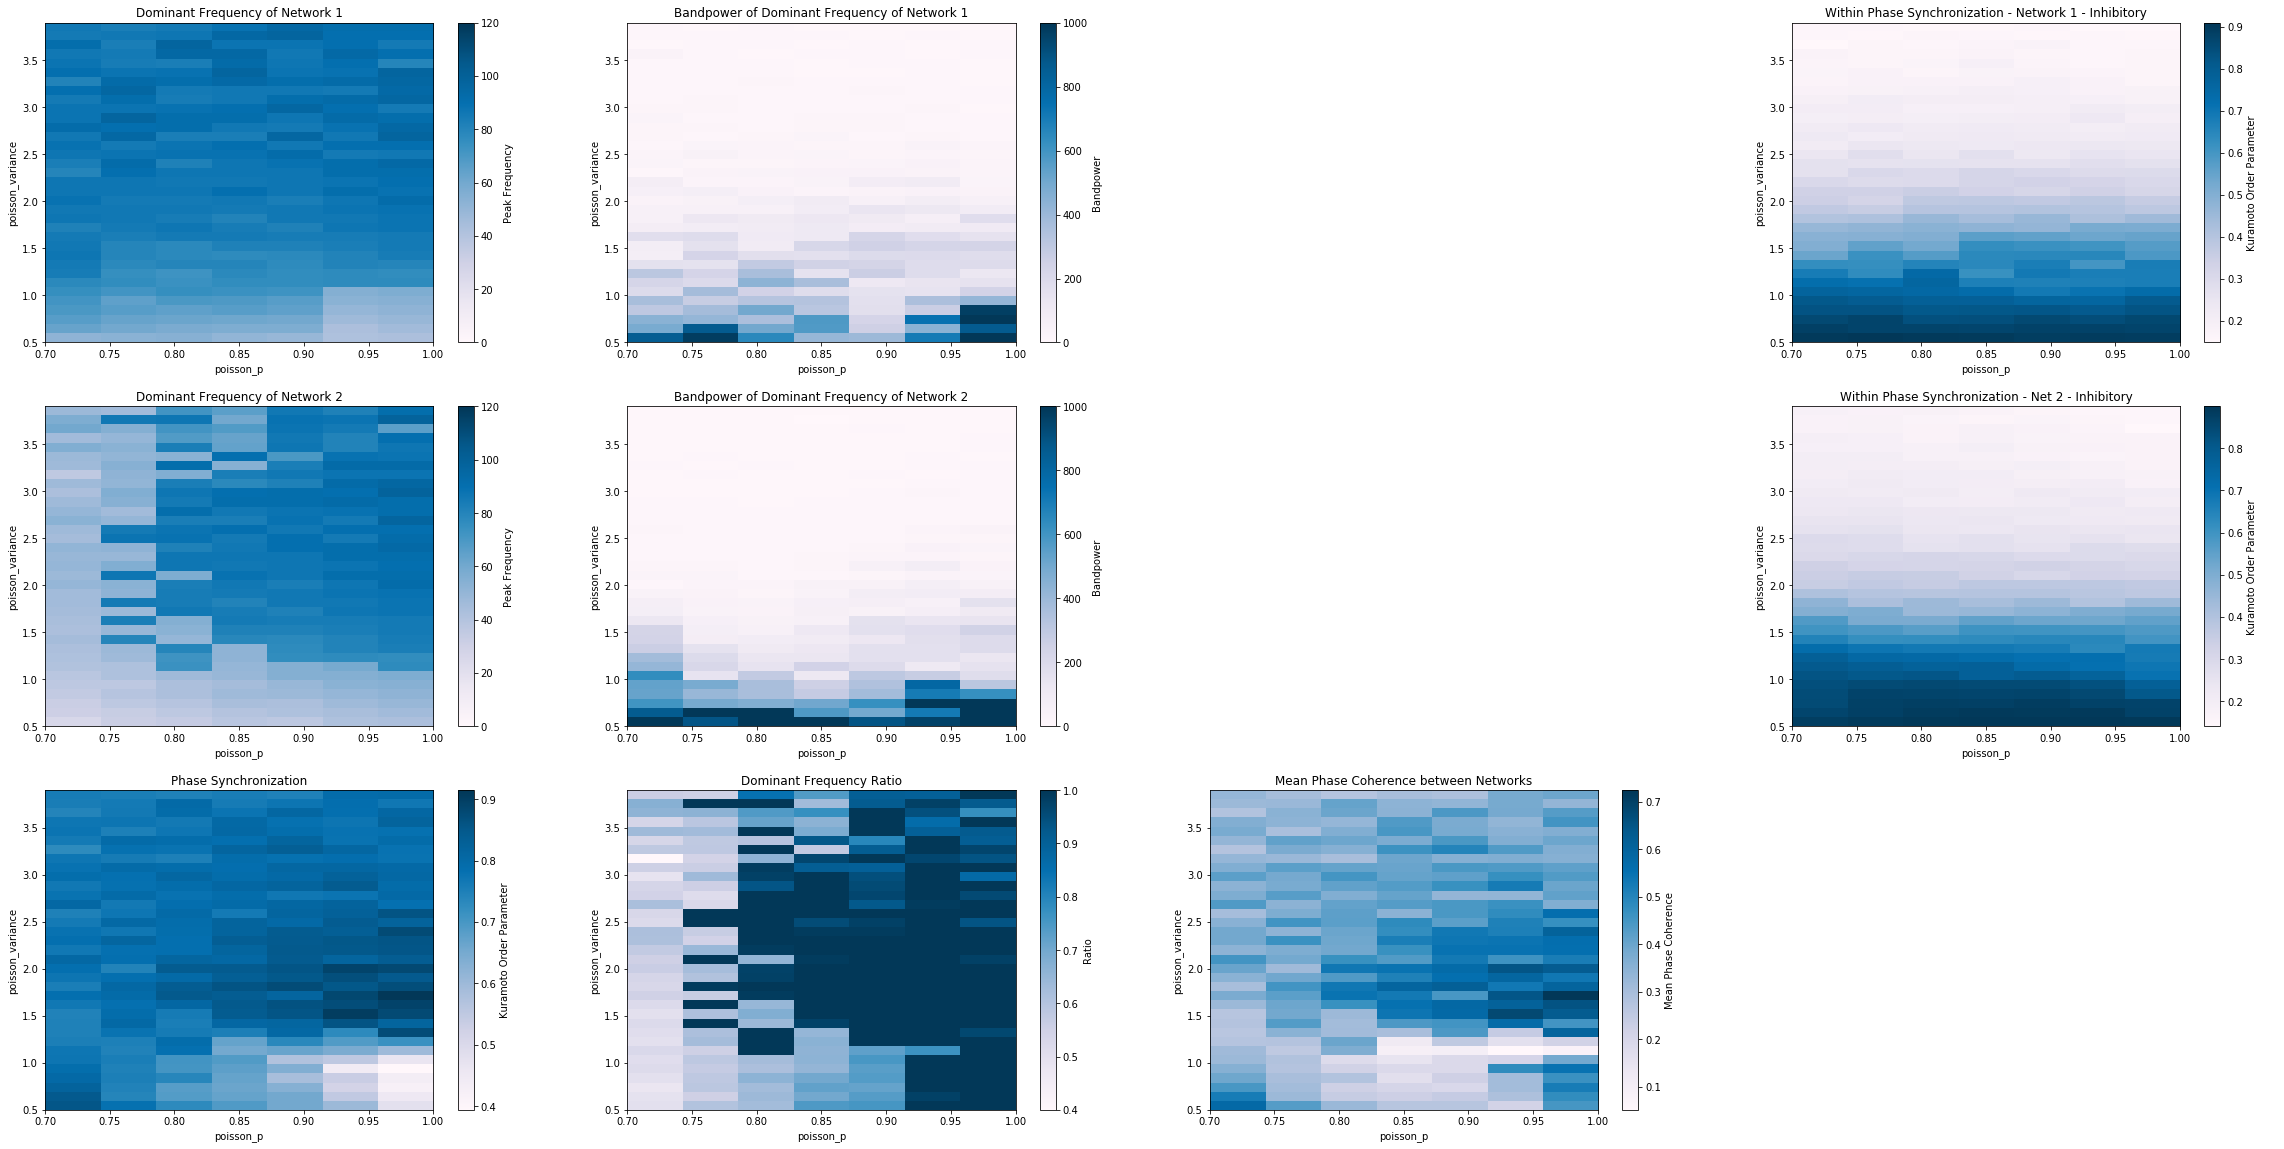

In [5]:
plots.plot_exploration(ex, vmin_ratio=None, vmin_phase=None, vmax_phase=None)

(<Figure size 720x576 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13420eb10>,
       dtype=object))

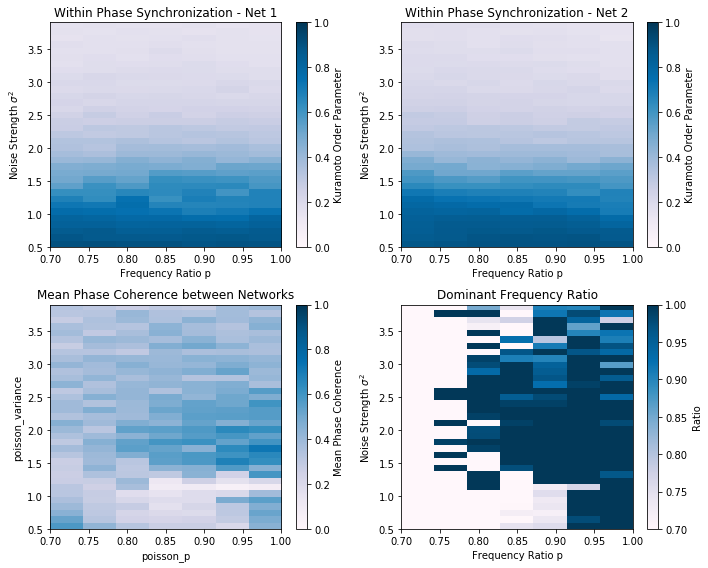

In [6]:
plots.plot_ING_exp_figure(ex, vmin_ratio=0.7, vmin_phase=0.0, vmax_phase=1.0)

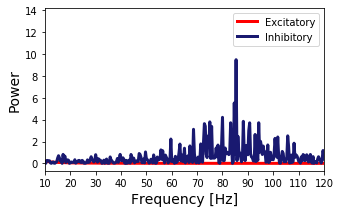

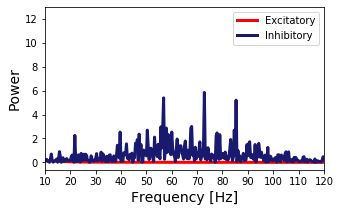

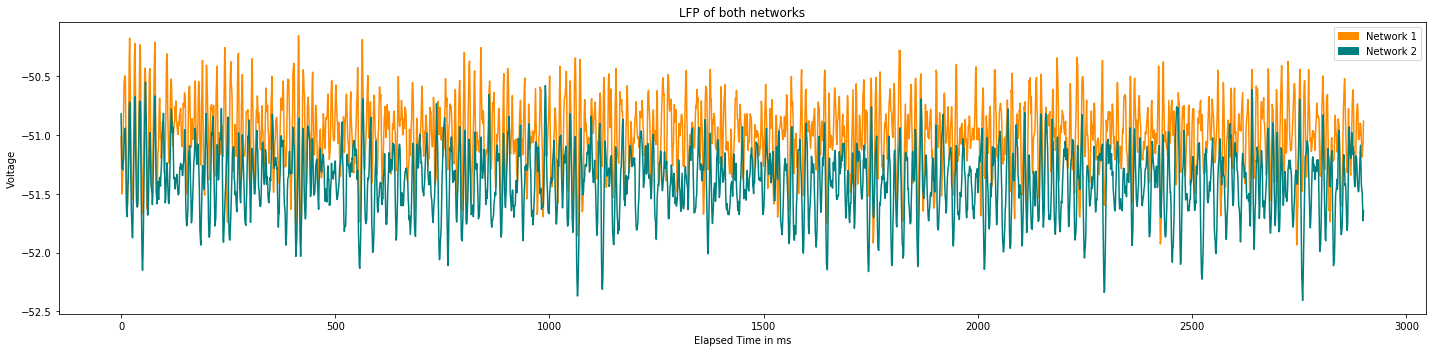

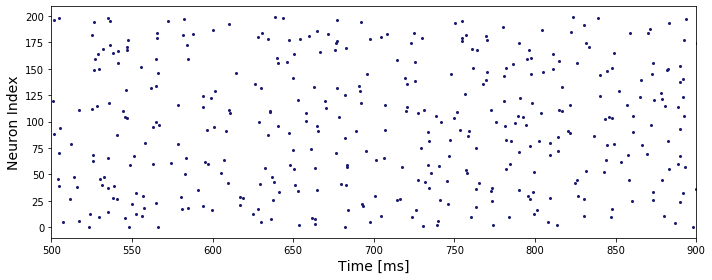

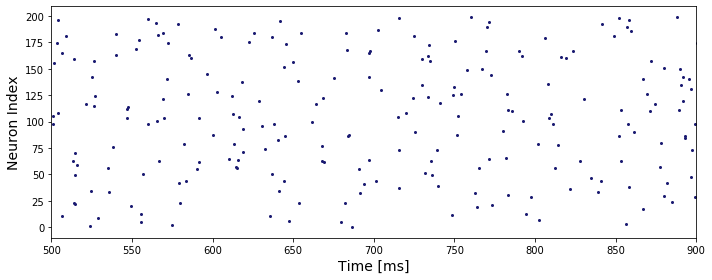

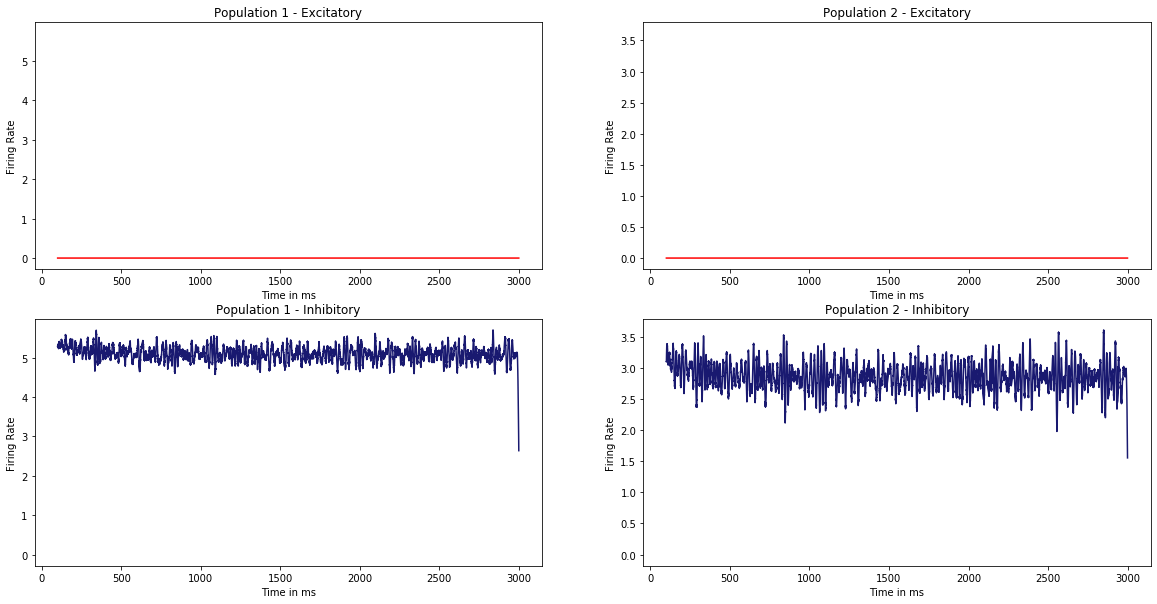

In [10]:
plots.plot_results(ex.get_run(240)) 